# Module 11. 特徵擷取(SIFT)

## 11-1: 擷取原理

> * 要辨識某物體的條件就是先掌握其特徵！由於我們要辨識的是某個物件而非整張相片，因此需要提取所謂稱為「Local features」的特徵，作法是先在影像中`選取重要的特徵點`，接著以其為 base 取得周圍的特徵（即local features），這些來自不同相片的 local features 會透過稍後會說明的 Feature matching 功能來比對是否有相同的物件。

> * 特徵點 → 局部特徵 → Feature matching 這些特性可用 `edges、corners、blobs (斑點)` 等組合來描述 Keypoint detection、Feature extraction 以及 Feature matching

>> * Keypoint detection ：在圖片中取得感興趣的關鍵點（可能為 edges、corners 或 blobs）。
>> * Feature extraction ：針對各關鍵點提取該區域的 features（我們稱為 local features）。
>> * 關鍵點篩選並進行 Feature matching。

>> https://gilscvblog.com/2013/08/18/a-short-introduction-to-descriptors/

## 11-2: Keypoint Descriptor
### FAST – FastFeatureDetector
> 原理簡單, 執行速度相當快, 主要用於偵測 corners，亦可偵測 blob。適用於要求速度的 real-time analysis, 適用於`速度慢或較低階的執行環境`。使用度極高，尤其在需要即時的 realtime 環境。

> * FAST 方法認為，一個以 p 為中心、半徑為 r 的圓形，若它位於一個所謂的 corner上，那麼該圓的圓周上必有連續 n 個點，其強度值`大於或小於中心點 p `加上一個指定的 threshold 門檻的強度值。如果是的話，該中心點 p 便被認為是 keypoint。

> * 考慮是否應該將中心像素 p 視為關鍵點。中心像素 p 具有灰度強度值 p ＝ 32。為了使該像素成為關鍵點，必須在圓的邊界上具有 n = 12 / 16 (一般 `3/4`) 個連續像素，`這些像素要不就比 p + t 亮，要不就比 p – t 暗`。在此示例中，假設 t = 16。

><img src="./image/KpFast01.png"  style='width:90%'></img>

><img src="./image/KpFast03.png"  style='width:50%'></img>

> FAST演算法提取角點的步驟：
> * 在圖像中選擇圖元 p，假設其灰度值為：Ip
> * 設置一個閾值 T，例如：Ip 的20%
> * 選擇 p 周圍半徑為 3 的圓上的 16 個圖元，作為比較圖元
> * 假設選取的圓上有`連續`的 N 個圖元`大於Ip+T或者小於 Ip−T`，那麼可以認為圖元 p 就是一個特徵點。（N 通常取12，即為 FAST-12；常用的還有 FAST-9, FAST-11）。

> 缺點 :
> * 檢測到的特徵點過多並且會出現 `紮堆` 的現象。這可以在第一遍檢測完成後，使用非最大值抑制（Non-maximal suppression），在`一定區域內僅保留回應極大值的角點`，避免角點集中的情況。
> * FAST 提取到的角點`沒有方向和尺度`資訊
> * SIFT 和 SURF 演算法都包含有各自的特徵點描述子的計算方法，而 FAST 不包含特徵點描述子的計算，僅僅只有特徵點的提取方法，這就需要一個特徵點描述方法來描述 FAST 提取到的特徵點，以方便特徵點的匹配

https://docs.opencv.org/3.4/df/d74/classcv_1_1FastFeatureDetector.html

## FAST

In [1]:
import numpy as np
import cv2
  
# load the image and convert it to grayscale
image = cv2.imread('./image/lenaColor.png')
# image = cv2.imread('./image/fruits.png')

orig = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
detector = cv2.FastFeatureDetector_create(threshold=None, nonmaxSuppression=False)        # Fast feature detector
kps = detector.detect(gray, None)

print(f'keypoints\t: {len(kps)}\ntype\t\t: {type(kps)}\n\n{kps[:10]}')

image = cv2.drawKeypoints(gray, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)   # image : image output

cv2.imshow('Images', np.hstack([orig, image]))
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

keypoints	: 11929
type		: <class 'tuple'>

(< cv2.KeyPoint 00000273369F3E10>, < cv2.KeyPoint 0000027355E63810>, < cv2.KeyPoint 0000027355E638A0>, < cv2.KeyPoint 0000027336A77E70>, < cv2.KeyPoint 0000027336A77E10>, < cv2.KeyPoint 0000027336A77F60>, < cv2.KeyPoint 0000027336A77F30>, < cv2.KeyPoint 0000027336A77E40>, < cv2.KeyPoint 0000027336A77ED0>, < cv2.KeyPoint 0000027336A77EA0>)


-1

### SIFT : Scale Invariant Feature Transform，尺度不變特徵變換。
> SIFT特徵對`旋轉、尺度縮放、亮度變化等保持不變性`，是一種非常穩定的局部特徵。

> Fast Keypoint 在影像旋轉的情況下也可以檢測到，但是如果減小(或者增加)影像的大小，可能會丟失影像的某些部分，甚至導致檢測到的角點發生改變。這樣的損失現像`需要一種與影像比例無關`的角點檢測方法來解決。尺度不變特徵變換 (Scale-Invariant Feature Transform, SIFT) 可以解決這個問題。

> SIFT 演算法利用 DoG (差分高斯)來提取關鍵點(或者說成特徵點)，DoG 的思維是用不同的尺度空間因子 (高斯正態分佈的標準差σ) 對影像進行平滑，然後比較平滑後圖像的區別，差別大的畫素就是特徵明顯的點，即可能是特徵點。對得到的所有特徵點，我們剔除一些不好的，SIFT運算元會把剩下的每個特徵點用一個128維的特徵向量進行描述

> * 原理較為複雜。
> * 主要針對 blob 偵測，不過亦可偵測 corners。
> * 可適應物件的 scale (大小變化)及 angle（旋轉角度）等情況。
> * 在DoG模型中，使用了`不同尺寸影像並套用高斯模糊`，`比較不同模糊比例之間的變化`，來決定是否為 keypoint。
> * 由於計算量大，DoG 的執行速度較慢，不適用於 realtime 的環境。
> * SIFT已廣泛的應用於電腦視覺領域，並成為評定新 keypoint detecter 的效率指標。

> 速度上 `ORB > SURF > SIFT，SURF的魯鈍性(抗干擾能力）更好一些`。

><img src="./image/sift_dog.jpg"  style='width:90%'></img>
><img src="./image/SIFT.png"  style='width:90%'></img>
https://aishack.in/tutorials/sift-scale-invariant-feature-transform-scale-space/

> ### SIFT 演算法: 
> 1. 準備輸入圖像的不同比例的副本。為每個比例創建八度比例圖像。
> 2. 對於每個八度比例，高斯模糊濾鏡會應用到所有強度增加的圖像。
> 3. 對八度內的所有兩個後續圖像計算高斯差（DoG）。
> 4. 掃描中間DoG相對於 26 鄰域的極值。通過在極值上應用高通濾波器來檢索特徵。
> 5. 確定特徵的`漸變，方向和位置`。

## SIFT

In [2]:
import numpy as np
import cv2
gray = cv2.imread('./image/lenaColor.png', 0)
sift=cv2.xfeatures2d.SIFT_create()    # create object
# sift = cv2.SIFT_create()
kp = sift.detect(gray, None)
print(f'kp[:5]\t:\n{kp[:5]}\n\n'
      f'len(kp)\t\t: {len(kp)}\n'
      f'kp[0].pt\t: {kp[0].pt}\n'
      f'kp[0].size\t: {kp[0].size}')

img = cv2.drawKeypoints(gray, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)   # output to 'img'
# img = cv2.drawKeypoints(gray, kp, None)   # out to 'img'
cv2.imshow('sift_kp', img)

cv2.imwrite('./image/lena_sift_kp.jpg', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

kp[:5]	:
(< cv2.KeyPoint 0000027336A49AE0>, < cv2.KeyPoint 0000027336A49690>, < cv2.KeyPoint 0000027336A49210>, < cv2.KeyPoint 0000027336A496F0>, < cv2.KeyPoint 0000027336A49600>)

len(kp)		: 1083
kp[0].pt	: (20.537546157836914, 74.47918701171875)
kp[0].size	: 13.18647289276123


-1

### sift / save keypoint

In [3]:
import numpy as np
import cv2

# gray = cv2.imread('./image/mybaby.jpg', 0)
gray = cv2.imread('./image/lenaColor.png', 0)

sift = cv2.xfeatures2d.SIFT_create()
# kp = sift.detect(gray,None)

# directly find keypoints and descriptors in a single step
kp, des = sift.detectAndCompute(gray, None)   # kp指關鍵點, des指關鍵點的特徵描述
print(f'kps count : {len(kp)}\ndes[0] :\n{des[0:2]}')
img = cv2.drawKeypoints(gray, kp, None)

np.save('./image/mybaby_sift_kp', des)
cv2.imshow('SIFT', img)
# cv2.waitKey(0)

cv2.imwrite('./image/mybaby_sift.jpg', img)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

kps count : 1083
des[0] :
[[  0.   1.   0.   1.  58. 153.   0.   0.  29.   0.   0.   1.  15.  68.
    2.  24.  42.   0.   0.   0.   0.   0.   0.  36.   0.   0.   0.   0.
    0.   0.   0.   0.  10.  34.   0.   0.  43. 153.   0.   0.  91.   2.
    0.   0.  55. 153.   9.  18. 153.  17.   0.   0.   1.  13.   5.  47.
   16.   3.   0.   0.   0.   0.   0.   2.  53. 153.   0.   0.   9.  48.
    0.   0.  24.  16.   0.   0.  45. 153.  27.  16. 153.  13.   0.   0.
    3.  54.  34.  67.  31.   5.   1.   4.   4.   0.   0.   3.  74. 153.
    0.   0.   1.   3.   1.   0.  25. 113.   2.   0.   9.  48.  11.   3.
   23.   3.   0.   1.   4.  24.  27.  48.   7.   0.   0.  10.  13.   0.
    0.   6.]
 [  0.   0.   0.   0.   0.   0.   1.   1.   0.   1.   9.  41.   6.   0.
    4.   9.  15.  24.  44.  34.   3.   0.   1.   4.   7.   4.   3.  10.
  132.   3.   0.   1.   0.   0.   2.  16.   4.   0.   0.   0.  10.  11.
   24. 158.  56.   1.   1.   0. 158.  65.  40.  72.   8.   0.   0.   5.
   43.   3.   0.  16. 158

-1

### SURF : This algorithm `is patented`
Speeded Up Robust Features。加速版的SIFT。
SURF的流程和 SIFT 比較類似，這些改進體現在以下幾個方面：<br>
 * 特徵點檢測是基於 Hessian 矩陣，依據 Hessian 矩陣行列式的極值來定位特徵點的位置。
 * 並且將 Hession 特徵計算與高斯平滑結合在一起，兩個操作通過近似處理得到一個核範本。
 * 在構建尺度空間時，使用`box filter`與源圖像卷積，而不是使用DoG運算元。
 * SURF 使用一階 Haar 小波在 x、y 兩個方向的回應作為構建特徵向量的分佈資訊。

SURF 演算法比 SIFT 快好幾倍，它吸收了 SIFT 演算法的思想。SURF 採用 Hessian 演算法檢測關鍵點。SURF 需要提供閾值，特徵隨著閾值的增加而減少。

In [5]:
# 跑不起來是正常的(因為有專利限制)
import numpy as np
import cv2
gray = cv2.imread('./image/lenaColor.png', 0)

surf = cv2.xfeatures2d.SURF_create()
# Find keypoints and descriptors directly
kp, des = surf.detectAndCompute(gray, None)
len(kp)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv_contrib\modules\xfeatures2d\src\surf.cpp:1028: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SURF::create'


### Brief
過程如下：

 * 為減少雜訊干擾，先對圖像進行高斯濾波（方差為2，高斯窗口為 9x9）<br>
 * 以特徵點為中心，取 SxS 的鄰域大視窗。在大視窗中隨機選取一對（兩個）5x5 的子視窗，比較子視窗內的圖元和（可用積分圖像完成），進行二進位賦值.（一般 S=31）其中，p(x)，p(y)分別隨機點 x=(u1, v1), y=(u2, v2) 所在 5x5 子視窗的圖元和.<br>
 * 在大視窗中隨機選取N對子視窗，重複步驟2 的二進位賦值，形成一個二進位編碼，這個編碼就是對特徵點的描述，即特徵描述子.（一般 N=256）<br>
非常重要的一點是：BRIEF 是一種特徵描述符，它不提供查找特徵的方法。所以我們不得不使用其他特徵檢測器，比如 SIFT 和 SURF 等。原始文獻推薦使用 CenSurE 特徵檢測器，這種演算法很快。而且 BRIEF 演算法對 CenSurE 關鍵點的描述效果要比 SURF 關鍵點的描述更好。

簡單來說 BRIEF 是一種對特徵點描述符計算和匹配的快速方法。這種演算法可以實現很高的識別率，除非出現平面內的大旋轉。

In [4]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt

img = cv2.imread('./image/lenaColor.png',0)
# star = cv2.xfeatures2d.StarDetector_create()
# kp = star.detect(img,None)

brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()  # 初始化BRIEF特徵提取器
kp, des = brief.compute(img, kp)                          # 計算特徵描述
img = cv2.drawKeypoints(img, kp, None, color=-1)

cv2.imshow('Brief', img)

print(f'size\t\t: {brief.descriptorSize()}\ndes.shape\t: {des.shape}\nlen\t\t: {len(kp)}\ndes[0] :\n{des[0]}')
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

size		: 32
des.shape	: (1023, 32)
len		: 1023
des[0] :
[ 94 135 184  64 232 137 161 215 228  28 232  47  72 141  54 215  39 120
 171 225 155 154 255 147 242 212  85 196 189  71  28  40]


-1

### Star

In [5]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt

img = cv2.imread('./image/lenaColor.png',0)

star = cv2.xfeatures2d.StarDetector_create()               # 初始化STAR檢測器
kp = star.detect(img,None)                                # 使用STAR尋找特徵點
img = cv2.drawKeypoints(img, kp, None, color=-1)
print(len(kp))
cv2.imshow('Star', img)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

179


-1

### ORB : ORiented Brief / Oriented FAST and Rotated BRIEF
> ORB亦是針對 FAST 的強化，但除了scale space invariance，亦加入了旋轉不變性(rotation invariance)。

> ORB原理有三大步驟：
> * Pyramid 圖像尺寸並進行各尺寸的FAST計算。
> * 使用 Harris keypoint detector的方法計算每個 keypoint分數（是否近似corner？），並進行排序，最多僅取500個keypoints，其餘則丟棄。
> * 於此第三步中加入旋轉不變性，使用「intensity centroid」計算每個 keypoint 的 rotation。ORB 與 BRISK 相同，繼承了 FAST 運算快速的特性，可適用於realtime分析。

ORB 是用來取代 SIFT 和 SURF 的，與兩者相比，ORB有更快的速度。ORB 用FAST來檢測關鍵點，用 BRIEF 來進行關鍵點特徵描述。

In [6]:
import cv2
import numpy as np
# image = cv2.imread('./image/blox.jpg')
image = cv2.imread('./image/lenaColor.png')

# image = cv2.imread('./image/lenaColor.png', cv2.COLOR_BGR2GRAY)

sift_feature = cv2.xfeatures2d.SIFT_create()
sift_kp = sift_feature.detect(image)
sift_out = cv2.drawKeypoints(image, sift_kp, None)

orb_feature = cv2.ORB_create()
orb_kp  = orb_feature.detect(image)
orb_out  = cv2.drawKeypoints(image, orb_kp, None)

font = 2;    lt = 16
loc = (10, 40); color = (255, 255, 255)
cv2.putText(image, 'original', loc, font, 1, color, 2, lt)
cv2.putText(sift_out, 'sift', loc, font, 1, color, 2, lt)
cv2.putText(orb_out, 'orb', loc, font, 1, color, 2, lt)

image = cv2.hconcat([image, sift_out, orb_out])

cv2.imshow('image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### Harris
> 速度相當快，但仍較 FAST 慢，不過偵測 corner 比起 FAST 準確一些。廣泛應用於偵測 edges 及 corners, Harris 可用於識別角點。此函數可以很好的檢測角點，這些角點在圖像旋轉的情況下也能被檢測到。但是如果減少或者增加圖像的尺寸，可能會丟失圖像的某些部分，也有可能增加圖像的角點。

In [7]:
import numpy as np
import cv2

img = cv2.imread('./image/lenaColor.png', 1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

dst = cv2.cornerHarris(gray, blockSize=5, ksize=3, k=0.04)  
# blockSize:檢測的臨點數, ksize:sobel邊緣檢測的核, k:目標函式的一個引數（一般取值較小）

#result is dilated for marking the corners, not important
# dst = cv2.dilate(dst, None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]
cv2.imshow('dst',img)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

## 11-3: Keypoint Matching

### match knn
> BFmatcher (暴力匹配)：計算匹配圖層的一個特徵描述子與待匹配圖層的所有特徵描述子的距離返回最近距離。<br>
> FlannBasedMatcher：是目前最快的特徵匹配演算法（最近鄰搜尋）

那麼這個這個DMatch資料結構究竟是什麼呢？<br>
它包含三個非常重要的資料分別是 queryIdx，trainIdx，distance
* queryIdx：測試圖像的特徵點描述符的下標（第幾個特徵點描述符），同時也是描述符對應特徵點的下標。
* trainIdx：樣本圖像的特徵點描述符下標,同時也是描述符對應特徵點的下標。
* distance：代表這怡翠匹配的特徵點描述符的`歐式距離`，數值越小也就說明倆個特徵點越相近。

In [12]:
import cv2

# ======== example 0 =================
# img1 = cv2.imread('./image/box.png')
# img2 = cv2.imread('./image/box_in_scene.png')

# ======== example 1 =================
# img1 = cv2.imread('./image/testpic.jpg')
# img2 = cv2.imread('./image/testpic2.jpg')

# ======== example 2 =================
# img1 = cv2.imread('./image/aiotbooks.jpg')
# img2 = cv2.imread('./image/aiotimage.jpg')

# ======== example 3 =================
img1 = cv2.imread('./image/mario.jpg')
img2 = cv2.imread('./image/marioCoin.jpg')

feature = cv2.xfeatures2d.SIFT_create()
# feature = cv2.xfeatures2d.SURF_create()   # This algorithm is patented and is excluded in this configuration

kp1, des1 = feature.detectAndCompute(img1, None)
kp2, des2 = feature.detectAndCompute(img2, None)

# ========= BFMatcher ================
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)  # k Count of best matches found per each query descriptor 叫出離最近的兩個點
# matches = bf.Match(des1, des2)  # k Count of best matches found per each query descriptor
# matches = sorted(matches, key = lambda x:x.distance)

print(f'len(matches)\t\t= {len(matches)} 組, \tk = 2\n')

for i in range(3) :
    print(f'matches[{i}]\t\t= {matches[i]}')
    for j in range(2) :
        print(f'matches[{i}][{j}].queryIdx\t= {matches[i][j].queryIdx}\n'
              f'matches[{i}][{j}].trainIdx\t= {matches[i][j].trainIdx}\n'
              f'matches[{i}][{j}].distance\t= {matches[i][j].distance:.2f}\n')
    print('-'*80)

good = []
for m, n in matches:
    if (m.distance < .4 * n.distance):      # #如果第一個鄰近距離比第二個鄰近距離的0.4倍小，則保留 try 0.5, 0.6, 0.7
#     if m.distance / n.distance < 0.4:      # #如果第一個鄰近距離比第二個鄰近距離的0.4倍小，則保留 try 0.5, 0.6, 0.7
#     if m.distance < 100:      # #如果第一個鄰近距離
        good.append(m)
print(f'Matching points : {len(good)}')
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, [good], outImg=None, 
        flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

img3 = cv2.resize(img3, None, fx=.6, fy=.6)
cv2.imshow('video', img3)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

len(matches)		= 2049 組, 	k = 2

matches[0]		= (< cv2.DMatch 0000027336A44490>, < cv2.DMatch 0000027357AE28B0>)
matches[0][0].queryIdx	= 0
matches[0][0].trainIdx	= 18
matches[0][0].distance	= 470.04

matches[0][1].queryIdx	= 0
matches[0][1].trainIdx	= 1
matches[0][1].distance	= 478.34

--------------------------------------------------------------------------------
matches[1]		= (< cv2.DMatch 0000027357AE2670>, < cv2.DMatch 0000027357AE26D0>)
matches[1][0].queryIdx	= 1
matches[1][0].trainIdx	= 18
matches[1][0].distance	= 381.12

matches[1][1].queryIdx	= 1
matches[1][1].trainIdx	= 6
matches[1][1].distance	= 391.64

--------------------------------------------------------------------------------
matches[2]		= (< cv2.DMatch 0000027357AE28F0>, < cv2.DMatch 0000027357AE2710>)
matches[2][0].queryIdx	= 2
matches[2][0].trainIdx	= 18
matches[2][0].distance	= 456.42

matches[2][1].queryIdx	= 2
matches[2][1].trainIdx	= 0
matches[2][1].distance	= 479.11

--------------------------------------------

-1

### orb match

In [15]:
import cv2

# ======== example 0 =================
# img1 = cv2.imread('./image/box.png')
# img2 = cv2.imread('./image/box_in_scene.png')

# ======== example 1 =================
# img1 = cv2.imread('./image/testpic.jpg')
# img2 = cv2.imread('./image/testpic2.jpg')

# ======== example 2 =================
img1 = cv2.imread('./image/aiotbooks01.jpg')
img2 = cv2.imread('./image/aiotimage.jpg')


orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)

matches = sorted(matches, key=lambda x:x.distance)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:60], outImg=None,
                       flags = cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# width, height, channel = img3.shape
# ratio = float(width) / float(height)
# img3 = cv2.resize(img3, (1024, int(1024 * ratio)))
cv2.imshow('image', img3)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### FLANN 是快速最近鄰搜尋包 (Fast_Library_for_Approximate_Nearest_Neighbors) 的簡稱。
> 它是一個對大資料集和高維特徵進行最近鄰搜尋的演算法的集合,而且這些演算法都已經被優化過了。在面對大資料集時它的效果要好於 BFMatcher。

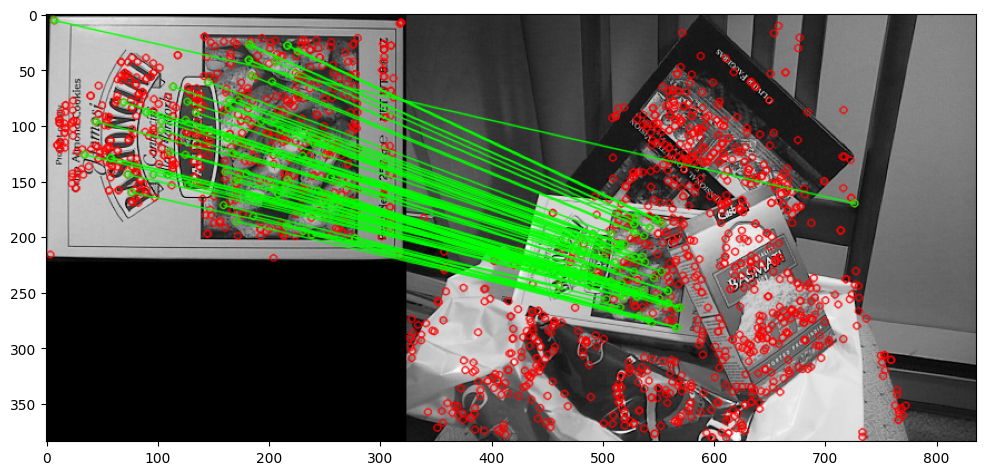

-1

In [16]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img1 = cv2.imread('./image/box.png', 0)  # queryImage
img2 = cv2.imread('./image/box_in_scene.png', 0)  # trainImage

# Initiate SIFT detector
# sift = cv2.SIFT()
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# ============= FLANN parameters ===========
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # or pass empty dictionary

# ============= Brute-Force ============
# bf = cv2.BFMatcher()
# matches = bf.knnMatch(des1, des2, k=2)

# ============= Flann ============
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0, 0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i] = [1, 0]

draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask,
                   flags=0)

img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)

plt.figure(figsize=(12, 6))
plt.imshow(img3, ), plt.show()

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

### homography

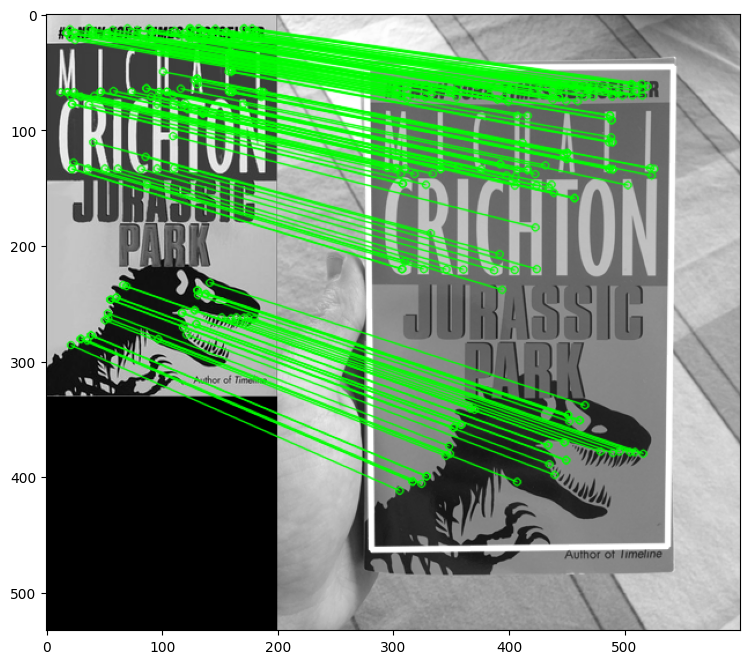

(<matplotlib.image.AxesImage at 0x27367cdda30>, None)

In [17]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10
# =======================================
# img1 = cv2.imread('./image/box.png', 0)    # Source Image
# img2 = cv2.imread('./image/box_in_scene.png', 0)    # Check Image
#=======================================
img1 = cv2.imread('./image/jp_01.png', 0)    # Source Image
img2 = cv2.imread('./image/jp_02.png', 0)    # Check Image

#=======================================
# img1 = cv2.imread('./image/douglas_01.png', 0)    # Source Image
# img2 = cv2.imread('./image/douglas_02.png', 0)    # Check Image

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
   
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print(f'Not enough matches are found - {len(good)}/{MIN_MATCH_COUNT}')
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
        singlePointColor = None,
        matchesMask = matchesMask, # draw only inliers
        flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

# cv2.imshow('Result', img3)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.figure(figsize=(10, 8))
plt.imshow(img3, 'gray'),plt.show()

---

<div style="page-break-after: always"></div>

# Module 12. 直方圖處理

## 12-1: 直方圖的含意
> 定義 : 直方圖反應了一張圖像內所有像素強度從 `0 至 255 的分佈情形`<br>
> 特色 : 能掌握圖像的明暗、對比及像素強度分布

> Histograms 是直方圖的意思，在攝影領域一般稱為`曝光直方圖`，主要用以分析一張照片的曝光是否正確。應用在電腦視覺則主要利用它來判斷白平衡、處理 thresholding，也可用於物體追蹤（例如 CamShift 演算法即使用彩色直方圖的變化達到跟蹤目的），另外也可用於圖像檢索目的（例如 Bag-of-words 詞袋演算法）、或應用於機器學習運算…等等。因為 Histograms 為我們統計出各像素`強度頻率`的資訊來呈現整張相片的色彩分佈情況，因此我們得以透過此資訊來猜測該圖片的物件及特性。

>><img src="./image/calcHist.jpg"  style='width:60%'>

### 直方圖均衡化，用於提高影像的質量, 直方圖均衡化是通過拉伸畫素`強度分佈範圍`來增強影像對比度的一種方法.
> 所謂直方圖就是對影像的中的這些畫素點的值進行統計，得到一個統一的整體的灰度概念。直方圖的好處就在於可以清晰瞭解影像的整體灰度分佈，這對於後面依據直方圖處理影像來說至關重要。

> 在開發影像處理的程式時，我們時常會需要觀察影像像素值的分佈與特性，以便選用適合的演算法、制定門檻值、設計出適合的影像處理流程。

><img src="./image/histogram_equalization.jpg"  style='width:90%'>

<div style="page-break-after: always"></div>

## 12-2: 直方圖均衡化

> 使用 cv2.calcHist 可產生指定圖片的直方圖資訊。<br>
> cv2.calcHist ( images, channels, mask, histSize, ranges )

> |引數      |說明                                                                          |
> |---------|------------------------------------------------------------------------------|
> |images   |要分析的圖片檔，其型別可以是 uint8 或 float32，變數必須放在中`括號當中`，例如：[img]。|
> |channels |產生的直方圖類型指定影像的通道（channel)。同樣必須放在中`括號當中`例：[0]→灰階，[0, 1, 2]→RGB三色。|
> |mask     |optional，若有提供則僅計算mask的部份。，若指定為 None 則會計算整張圖形的所有像素。  |
> |histSize |要切分的像素強度值範圍，`預設為256`。每個channel皆可指定一個範圍（bins)。例如，[32,32,32] 表示RGB三個channels皆切分為32區段，也就是圖形畫出來要有幾條長方形。                                  |
> |ranges   |X軸(像素強度)的範圍，`預設為[0,256]`）。|

https://zh.wikipedia.org/zh-tw/%E7%9B%B4%E6%96%B9%E5%9B%BE%E5%9D%87%E8%A1%A1%E5%8C%96

## 12-3: 實作直方圖

### Gray image

2765 262144


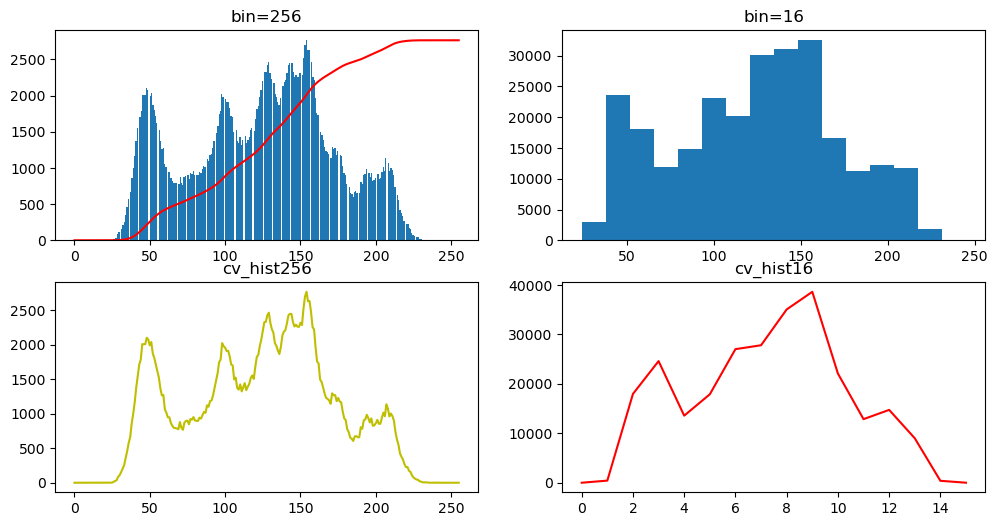

-1

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

o = cv2.imread('./image/lenaColor.png', 0)
cv2.imshow('original', o)
cv_hist256 = cv2.calcHist([o], [0], None, [256], [0,255])
cv_hist16 = cv2.calcHist([o], [0], None, [16], [0,255])

hist, bins = np.histogram(o.flatten(), 256, [0,256])  # 拉平
cdf = hist.cumsum()                                  # 累加 cdf : cumulate distribution function
cdf_normalized = cdf * hist.max()/ cdf.max()         # 標準化(壓縮到一定範圍，關係位置不太變化)
print(hist.max(), cdf.max())

fig=plt.figure(figsize=(12, 6))
plt.subplot(221)  
plt.hist(o.ravel(), 256); plt.title('bin=256')       # ravel 將多維陣列轉換為一維陣列的功能 like flatten
plt.plot(cdf_normalized, color='r')                 # plot cdf

plt.subplot(222)  
plt.hist(o.ravel(), 16);  plt.title('bin=16')

plt.subplot(223)  
plt.plot(cv_hist256, color='y');  plt.title('cv_hist256')

plt.subplot(224)  
plt.plot(cv_hist16, color='r');  plt.title('cv_hist16')

plt.show()

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

### color image : cv mean

mean :
[[105.41263199]
 [ 99.05646133]
 [180.22401428]]

std :
[[34.06085252]
 [52.8770734 ]
 [49.04857489]]


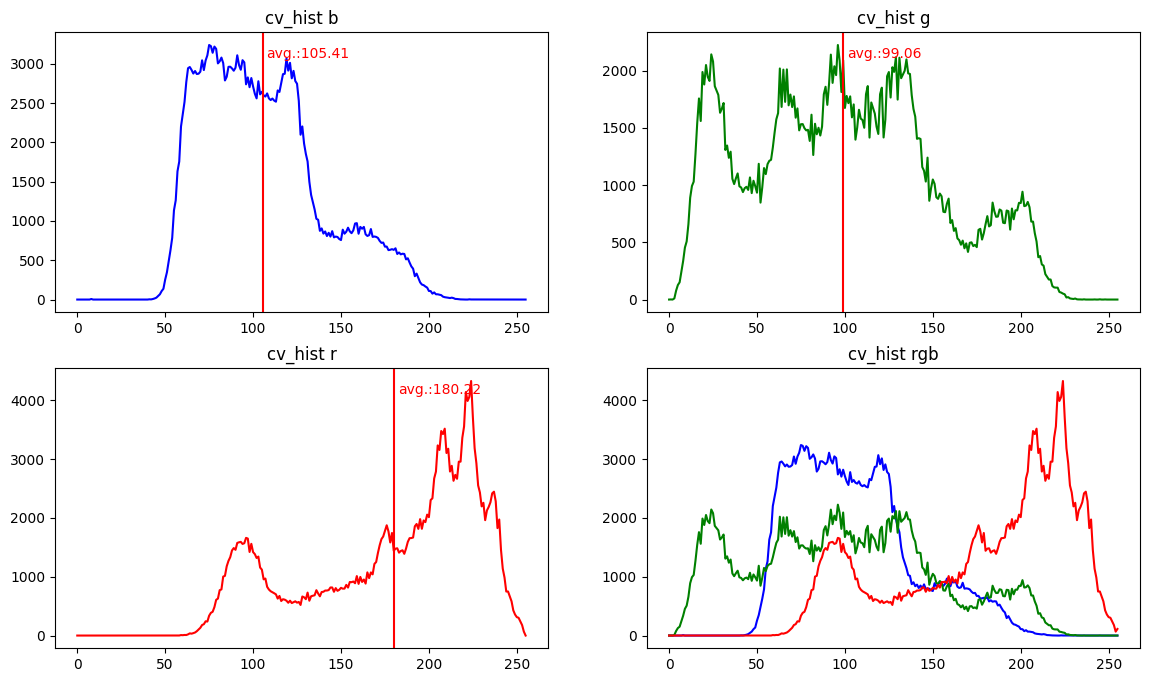

-1

In [18]:
import cv2
import matplotlib.pyplot as plt

o=cv2.imread('./image/lenaColor.png')
cv2.imshow('original', o)

cv_histb = cv2.calcHist([o], [0], None, [256], [0,255])   # [0] B
cv_histg = cv2.calcHist([o], [1], None, [256], [0,255])   # [1] G
cv_histr = cv2.calcHist([o], [2], None, [256], [0,255])   # [2] R

mean, std = cv2.meanStdDev(o);    print(f'mean :\n{mean}\n\nstd :\n{std}')
fig=plt.figure(figsize=(14, 8))

plt.subplot(221)  
plt.plot(cv_histb, color='b');  plt.title('cv_hist b');  plt.axvline(x=mean[0], color='r')
plt.text(mean[0]+2, cv_histb.max()*.95, f'avg.:{mean[0][0]:.2f}', color='r', fontsize=10)        

plt.subplot(222)  
plt.plot(cv_histg, color='g');  plt.title('cv_hist g');  plt.axvline(x=mean[1], color='r')
plt.text(mean[1]+2, cv_histg.max()*.95, f'avg.:{mean[1][0]:.2f}', color='r', fontsize=10)        

plt.subplot(223)  
plt.plot(cv_histr, color='r');  plt.title('cv_hist r');  plt.axvline(x=mean[2], color='r')
plt.text(mean[2]+2, cv_histr.max()*.95, f'avg.:{mean[2][0]:.2f}', color='r', fontsize=10)        

color = ('b', 'g', 'r')
plt.subplot(224);  plt.title('cv_hist rgb')
for i, col in enumerate(color):
    histr = cv2.calcHist([o], [i], None, [256], [0, 256])
    plt.plot(histr, color = col)

plt.show()

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

### Gray Level 直方圖均衡化處理實例 Histogram Equalization (HE)
> 定義 : 通過拉伸影像的像素強度分佈範圍來`增強圖像對比度`，適用於`過曝或背光的圖片`<br>
> 缺點 : 對處理的數據不加選擇(全局處理)，如此一來`會增加背景雜訊的對比度`並且`降低有用訊號(特別亮或暗)的對比度`

經過比較可以發現均衡化後的圖像明亮的部分出現了`過曝`，失去了原本的細節。這是因為原圖整體暗的部份較多，而經過直方圖均衡化後使原本亮的地方更亮，

### gray level Histogram Equalization

262144


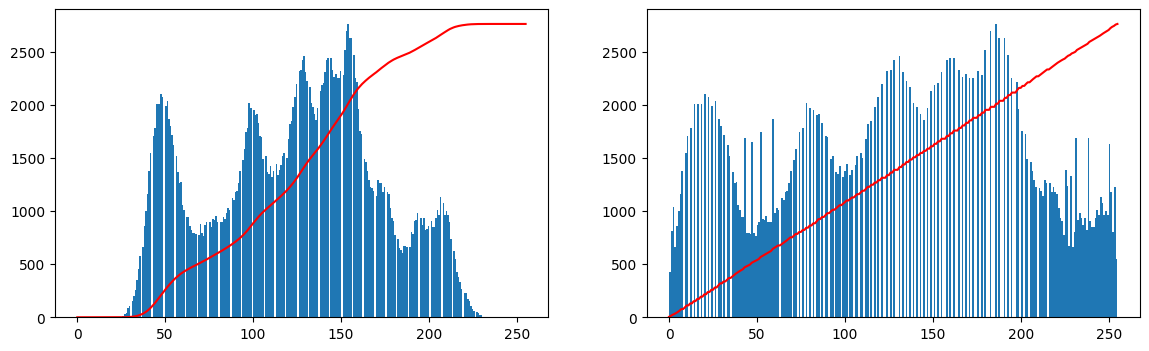

-1

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

o = cv2.imread('./image/lenaColor.png', 0)
equ=cv2.equalizeHist(o)

# cv2.imshow('original', o)
# cv2.imshow('equ', equ)
print(o.size)

hist, bins = np.histogram(o.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized_o = cdf * hist.max()/ cdf.max()

hist, bins = np.histogram(equ.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized_eq = cdf * hist.max()/ cdf.max()

fig=plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.hist(o.ravel(), 256)
plt.plot(cdf_normalized_o, color='r')

plt.subplot(122)  
plt.hist(equ.ravel(), 256)
plt.plot(cdf_normalized_eq, color='r')
plt.show()

cv2.imshow('original', o)
cv2.imshow('gray_equ', equ)
cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

### Color 均衡化處理實例

In [21]:
import cv2
import numpy as np

img = cv2.imread('./image/lenaColor.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

equ = cv2.equalizeHist(gray)     # 灰度圖均衡化

result1 = np.hstack((gray, equ))  # 水平拼接原圖和均衡圖
cv2.imshow('grey_equ', result1)

(b, g, r) = cv2.split(img)        # 彩色影像均衡化,需要分解通道 對每一個通道均衡化
bH = cv2.equalizeHist(b)
gH = cv2.equalizeHist(g)
rH = cv2.equalizeHist(r)

equ2 = cv2.merge((bH, gH, rH))    # 合併每一個通道

result2 = np.hstack((img, equ2)) # 水平拼接原圖和均衡圖
cv2.imshow('bgr_equ', result2)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### 自適應直方圖均衡 Adaptive Histogram Equalization AHE

> 為了提高影像的`區域性對比度`, 將影像分成`若干子塊對子塊進行HE處理`，這便是AHE（自適應直方圖均衡化）
它在每一個小區域內`（預設 8×8 ）`進行直方圖均衡化。當然，如果有噪點的話，噪點會被放大，需要對小區域內的對比度進行了限制。

> * 演算法 ：與一般的直方圖均衡 (全局) 相比，AHE 透過計算圖像每一個顯著`區域的直方圖`，重新分佈圖像的亮度值來改變影像對比度。
> * 優點 ：適合於改善影像的區域性對比度以及獲得更多的影像細節。
> * 缺點 ：在對比度增強的同時，也放大了影像的噪音，

>限制對比度自適應直方圖均衡 Contrast Limited Adaptive Histogram Equalization CLAHE 演算法 ：CLAHE與AHE都是局部均衡化，也就是把整個圖像分成許多小塊Tiles (OpenCV default為8×8)，對每個小塊進行均衡化。這種方法主要對於圖像直方圖不是那麼單一的圖像(e.g. 多峰情況)比較實用。所以在每一個的區域中，直方圖會集中在某一個小的區域中
> * clipLimit 參數表示對比度的大小。 
> * tileGridSize 參數表示每次處理塊的大小 。<br>

https://iter01.com/518513.html

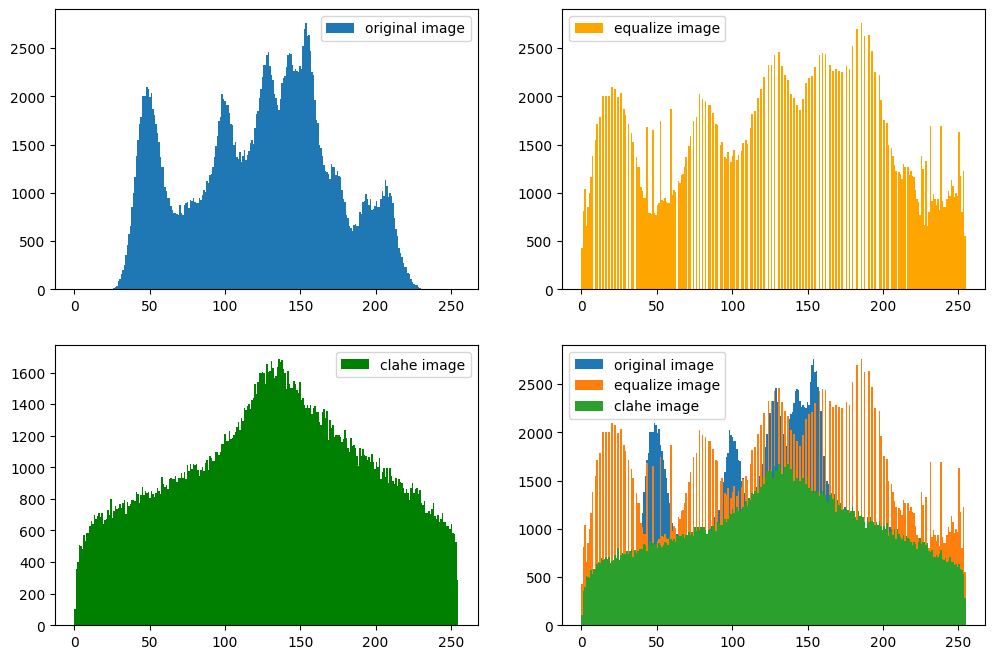

In [22]:
import cv2
import numpy as np

img = cv2.imread('./image/lenaColor.png', 0)

# 全域性直方圖均衡
equ = cv2.equalizeHist(img)

# 自適應直方圖均衡
clahe = cv2.createCLAHE(clipLimit = 80.0, tileGridSize = (18, 18))  # AHE   # default cliplimit  = 40 
cl1 = clahe.apply(img)

# 水平拼接三張影像
result1 = np.hstack((img, equ, cl1))
cv2.imshow('clahe_result', cv2.resize(result1, (0,0), fx=.8, fy=.8))

fig=plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.hist(img.ravel(), 256, [0, 255], label='original image'), plt.legend()

plt.subplot(222)
plt.hist(equ.ravel(), 256, [0, 255], label='equalize image', color='orange'), plt.legend()

plt.subplot(223)
plt.hist(cl1.ravel(), 256, [0, 255], label='clahe image', color='g'), plt.legend()

plt.subplot(224)
plt.hist(img.ravel(), 256, [0, 255], label='original image')
plt.hist(equ.ravel(), 256, [0, 255], label='equalize image')
plt.hist(cl1.ravel(), 256, [0, 255], label='clahe image')
plt.legend()

cv2.waitKey()
cv2.destroyAllWindows()

---

<div style="page-break-after: always"></div>

# Module 13. 視訊處理
> 介紹如何使用 OpenCV 擷取網路攝影機影像，處理與顯示即時的畫面影像，並將連續的畫面影像寫入影片檔案中儲存起來。網路攝影機的串流影像，可以透過 OpenCV 模組的 VideoCapture 影片擷取功能來達成，至於寫入影片檔則可使用 VideoWriter

## 13-1:視訊預覽
> 在準備擷取攝影機的影像之前，要先呼叫 cv2.VideoCapture 建立一個 VideoCapture 物件，這個 VideoCapture 物件會連接到一隻網路攝影機，我們可以靠著它的參數來指定要使用那一隻攝影機（0 代表第一隻、1 代表第二隻）。

> 建立好 VideoCapture 物件之後，就可以使用它的 read 函數來擷取一張張連續的畫面影像了。

> 在這個無窮迴圈中，每次呼叫 cap.read() 就會讀取一張畫面，其第一個傳回值 ret 代表成功與否（True 代表成功，False 代表失敗），而第二個傳回值 frame 就是攝影機的單張畫面。

>### play video file or camera preview
> * cap = VideoCapture([index, file]) 開啟相機裝置 index, 視訊檔案 file
> * retval = VideoCapture.isOpened()  : True, False 判斷視訊捕獲是否初始化成功。初始化成功返回true
> * ret, frame = cap.read() : 
> * cap.release()

In [23]:
import numpy as np
import cv2

# cap = cv2.VideoCapture('./video/chaplin.mp4')   # play video file
cap = cv2.VideoCapture(0)                     # from camera

fps = cap.get(cv2.CAP_PROP_FPS)               # Frame Per Second
F_Count = cap.get(cv2.CAP_PROP_FRAME_COUNT)   # frame count
print(f'fps : {fps:.2f} f/s, Frame_Count : {F_Count}')

while cap.isOpened():
    ret, frame = cap.read()
    if not ret or cv2.waitKey(1) == 27: break

    frame = cv2.flip(frame, 1)   # left side right
    c=cv2.waitKey(30)            # 25 ms per frame     1/fps

#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imshow('frame',frame)

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

fps : 30.00 f/s, Frame_Count : -1.0


-1

### Play video in jupyter lab

In [24]:
from IPython.display import HTML

HTML('''
    <video alt='test' controls>
        <source src='./video/chaplin.mp4' type='video/mp4'>
    </video>
''')

## 13-2: 視訊讀寫

### imWrite : image writer
* cv2.WINDOW_NORMAL : ``可以`` 讓使用者改變視窗大小
* cv2.WINDOW_AUTOSIZE : 使用者 ``不可`` 改變視窗大小
* CAP_PROP_FRAME_WIDTH, CAP_PROP_FRAME_HEIGHT : 取的影像的長寬
* cv2.VideoCapture.set( propid, value )

|類別                       | propId | 說明                                  |
|---------------------------|:------:|---------------------------------------|
|cv2.CAP_PROP_POS_MSEC      | 0      | 視訊檔案的當前位置（ms）                |
|`cv2.CAP_PROP_POS_FRAMES`    | 1      | 從0開始索引幀，幀位置。                 |
|cv2.CAP_PROP_POS_AVI_RATIO | 2      | 視訊檔案的相對位置（0表示開始，1表示結束）|
|`cv2.CAP_PROP_FRAME_WIDTH`   | 3    | 視訊流的幀寬度                         |
|`cv2.CAP_PROP_FRAME_HEIGHT`  | 4    | 視訊流的幀高度                         |
|`cv2.CAP_PROP_FPS`           | 5    | 幀率                                  |
|`cv2.CAP_PROP_FOURCC`        | 6    | 編解碼器四字元程式碼                   |
|`cv2.CAP_PROP_FRAME_COUNT`   | 7    | 視訊檔案的幀數                         |
|cv2.CAP_PROP_FORMAT        | 8      | retrieve()返回的Mat物件的格式          |
|cv2.CAP_PROP_MODE          | 9      | 後端專用的值，指示當前捕獲模式           |
|cv2.CAP_PROP_BRIGHTNESS    | 10     | 影像的亮度，僅適用於支援的相機           |
|cv2.CAP_PROP_CONTRAST      | 11     | 影像對比度，僅適用於相機                |
|cv2.CAP_PROP_SATURATION    | 12     | 影像飽和度，僅適用於相機                 |
|cv2.CAP_PROP_HUE           | 13     | 影像色調，僅適用於相機                   |
|cv2.CAP_PROP_GAIN          | 14     | 影像增益，僅適用於支援的相機             |
|cv2.CAP_PROP_EXPOSURE      | 15     | 曝光，僅適用於支援的相機                 |
|cv2.CAP_PROP_CONVERT_RGB   | 16     | 布林標誌，指示是否應將影像轉換為RGB       |

### take 1 picture manually 影片截圖

In [25]:
import cv2
# import datetime as dt
from datetime import datetime as dt
now_dt = dt.now().strftime('%m/%d/%Y %H:%M:%S')

# cv2.namedWindow('frame', cv2.WINDOW_NORMAL)
# cap = cv2.VideoCapture('./video/chaplin.mp4')   # play video file
cap = cv2.VideoCapture(0)                         # from camera
font = 2;    lt = 16
print(f'frame_w\t\t: {cap.get(cv2.CAP_PROP_FRAME_WIDTH)}\n'
      f'frame_fps\t: {cap.get(cv2.CAP_PROP_FPS)}\n'
      f'frame_count\t: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}')

# ratio = cap.get(cv2.CAP_PROP_FRAME_WIDTH) / cap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # cap.get得到相機/視訊檔案的屬性
# w = 500;  h = int(w / ratio)

# cv2.resizeWindow('frame', w, h)       # change frame size
count=0
while True:
    ret, frame = cap.read()                          #  read frame : ret: True/ False,  frame:image
    if not ret or cv2.waitKey(30) == 27: break             # wait for 1 ms     
    
    frame = cv2.flip(frame, 1)                       # 0 : 上下左右顛倒,  -1 : 上下顛倒
    
    if cv2.waitKey(1)==ord('t') or cv2.waitKey(1)==ord('T'):    # 點擊t會儲存照片
        cv2.putText(frame, now_dt, (100, 300), font, 1, (0,0,255), 2, lt)
        cv2.imwrite(f'./image/frame{count}.jpg', frame)     # save frame as JPEG file          
        print(f'save image : frame{count}.jpg')
        count+=1 
        
#     frame = cv2.resize(frame, (w, h))
    cv2.putText(frame, f'{cap.get(cv2.CAP_PROP_POS_FRAMES):.0f} frames, {cap.get(cv2.CAP_PROP_POS_MSEC):.0f} ms', 
                (50, 250), font, .8, (0,0,255), 2, lt)

    cv2.imshow('frame', frame)
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)   

frame_w		: 640.0
frame_fps	: 30.0
frame_count	: -1.0
save image : frame0.jpg
save image : frame1.jpg
save image : frame2.jpg


-1

### capture 3 images from video

In [28]:
import cv2
from datetime import datetime as dt
now_dt = dt.now().strftime('%m/%d/%Y %H:%M:%S')

vidcap = cv2.VideoCapture('./video/chaplin.mp4')
font = 2;    lt = 16
success, image = vidcap.read()
count = 0
while success and count < 3:
    print('Read a new frame :', success)
    success, image = vidcap.read()
    cv2.putText(image, now_dt+' cap 3', (100, 300), font, 1, (0,0,255), 2, lt)
    cv2.imwrite('./image/frame%d.jpg' % count, image)     # save frame as JPEG file      
    print(f'Write a new frame: frame{count}.jpg\n'+'='*20)
    count += 1

Read a new frame : True
Write a new frame: frame0.jpg
Read a new frame : True
Write a new frame: frame1.jpg
Read a new frame : True
Write a new frame: frame2.jpg


## 13-3: 視訊物件ROI, 追蹤和去背景

### track one obj in video file

In [31]:
# 先匡選，再按enter

import cv2

# cap = cv2.VideoCapture('./video/vtest.avi')
cap = cv2.VideoCapture('./video/overpass.mp4')
# cap = cv2.VideoCapture('./video/car_chase_01.mp4')

tracker = cv2.TrackerCSRT_create()

# tracker = cv2.TrackerBoosting_create()   # error
# tracker = cv2.TrackerMIL_create()
# tracker = cv2.TrackerKCF_create()
# tracker = cv2.TrackerTLD_create()            # error
# tracker = cv2.TrackerMedianFlow_create()       # error
# tracker = cv2.TrackerGOTURN_create()          # error
# tracker = cv2.TrackerMOSSE_create()         # errro

roi = None
while True:
    ret, frame = cap.read()
    if not ret or cv2.waitKey(40) == 27  : break
    
    if roi is None:
        roi = cv2.selectROI('frame', frame)
        if roi != (0, 0, 0, 0):
            tracker.init(frame, roi)

    success, rect = tracker.update(frame)
    if success: 
        (x, y, w, h) = [int(i) for i in rect]
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 255, 0), 2)

    cv2.imshow('frame', frame)
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1) 

-1

### Track one obj in live Camera

In [33]:
import cv2, time

cap = cv2.VideoCapture(0)
tracker = cv2.TrackerCSRT_create()

# tracker = cv2.TrackerBoosting_create()       # error
# tracker = cv2.TrackerMIL_create()
# tracker = cv2.TrackerKCF_create()
# tracker = cv2.TrackerTLD_create()            # error
# tracker = cv2.TrackerMedianFlow_create()     # error
# tracker = cv2.TrackerGOTURN_create()         # error
# tracker = cv2.TrackerMOSSE_create()          # errro
time.sleep(3)
roi = None
while True:
    ret, frame = cap.read()
    if not ret or cv2.waitKey(30) == 27: break
    
    frame = cv2.flip(frame, 1)
    
    if roi is None:
        roi = cv2.selectROI('frame', frame)
        if roi != (0, 0, 0, 0):
            tracker.init(frame, roi)

    success, rect = tracker.update(frame)
    if success: 
        (x, y, w, h) = [int(i) for i in rect]
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 255, 0), 2)

    cv2.imshow('frame', frame)
cap.release()        
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### ROI (Region Of Interest) 只處理部分有興趣的

In [34]:
import cv2

# 指定 ROI 座標位置
RECT = ((320, 20), (570, 390))
(left, top), (right, bottom) = RECT

def roiarea(frame):                  # 取出 ROI 子畫面
    return frame[top:bottom, left:right]

def replaceroi(frame, roi):             # 將 ROI 區域貼回到原畫面
    frame[top:bottom, left:right] = roi
    return frame

cap = cv2.VideoCapture(0)               # 開啟攝影機, 讀取畫面
ratio = cap.get(cv2.CAP_PROP_FRAME_WIDTH) / cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

w = 800
h = int(w / ratio)

while True:
    ret, frame = cap.read()
    if not ret or cv2.waitKey(30) == 27: break
    frame = cv2.resize(frame, (w, h))
    frame = cv2.flip(frame, 1)

    roi = roiarea(frame)                   # 取出子畫面
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)        # BGR to HSV
#     roi = cv2.cvtColor(roi, cv2.COLOR_BGR2XYZ)          # BGR to XYZ
    
    frame = replaceroi(frame, roi)         # 將處理完的子畫面貼回到原本畫面中
    
    cv2.rectangle(frame, RECT[0], RECT[1], (0,0,255), 2)      # 在 ROI 範圍處畫個框
    cv2.imshow('frame', frame)
    
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1) 

-1

### framediff : 去背景 video

In [35]:
import cv2
# cap = cv2.VideoCapture('./video/vtest.avi')
cap = cv2.VideoCapture(0)

bg = None

while True:
    ret, frame = cap.read()
    if not ret or cv2.waitKey(30) == 27 : break
        
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # gray = cv2.GaussianBlur(gray, (17, 17), 0)       # 去雜訊
    if bg is None:
        bg = gray                                    # read gray which is inital image
        continue

    diff = cv2.absdiff(gray, bg)
    diff = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)[1]  # binary 後, 只有黑和白 (0, 1)
    diff = cv2.erode(diff, None, iterations=2)
    diff = cv2.dilate(diff, None, iterations=2)
    # diff = cv2.morphologyEx(diff,cv2.MORPH_OPEN, None, iterations=2)

    cnts, hierarchy = cv2.findContours(
        diff, 
        cv2.RETR_EXTERNAL,             # 若有重複, 只找外圈的
        cv2.CHAIN_APPROX_SIMPLE)       # 傳回特徵性座標, 如長 寬 高
    
    for c in cnts:
        if cv2.contourArea(c) < 500:    # try < 100  面積小於 500 不要 show 
            continue
            
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)

    cv2.imshow('frame', frame)
cap.release()        
cv2.destroyAllWindows()
cv2.waitKey(1)  

-1

---

<div style="page-break-after: always"></div>

# Module 14. OpenCV 函式庫 DLib 介紹（Python）
> Dlib 使用的人臉偵測演算法是以方向梯度直方圖 Histogram of Oriented Gradients（HOG）的特徵加上線性分類器（linear classifier）、影像金字塔（image pyramid）與滑動窗格（sliding window）來實作的

## 14-1: DLib 影像辨識應用
> dlib 是一套包含了機器學習、計算機視覺、圖像處理等的函式庫，使用 C++ 開發而成，目前廣泛使用於工業及學術界，也應用在機器人、嵌入式系統、手機、甚至於大型的運算架構中，而且最重要的是，它不但開源且完全免費，而且可跨平台使用（Linux、Mac OS、Windows），並且除了 C++ 之外還提供了 Python API ，因此如果我們想要建立一套物件偵測系統，dlib 是相當適合的平台。

## 14-2: DLib 套件應用
> pip install dlib==19.8.1<br>
> ( or dlib-19.8.1-cp36-cp36m-win_amd64.whl ) (**python 3.6.X**)
## 14-3: DLib 特徵點描述

> ### 照片人臉偵測
> detector 函數的第二個參數是指定不取樣（unsample）的次數，如果`圖片太小的時候`，將其設為 1 可讓程式偵較容易測出更多的人臉。

In [63]:
import dlib
import cv2
print(f'dlib ver.\t: {dlib.__version__}\n\t\t: {dlib.__file__}\n\n')

dlib ver.	: 19.24.1
		: C:\Users\Tibame_EX14\anaconda3\envs\opencv\lib\site-packages\dlib\__init__.py




In [64]:
img = cv2.imread('./image/dlib.jpg')   # 讀取照片圖檔
# img = cv2.imread('./image/faces02.png')
# img = cv2.imread('./image/face03.jpg')

detector = dlib.get_frontal_face_detector()  # Dlib 的人臉偵測器

face_rects = detector(img, 1)   # try (img, 0)   # 偵測人臉：0只偵測大臉
print(f'detected face numder : {len(face_rects)}')

# 取出所有偵測的結果
for i, d in enumerate(face_rects):
    x1, y1, x2, y2 = d.left(), d.top(), d.right(), d.bottom()
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 4, cv2.LINE_AA)  # 以方框標示偵測的人臉

cv2.imshow('Face Detection', img)     # 顯示結果

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

detected face numder : 8


-1

### 偵測結果與分數
>改用 detector.run 來偵測人臉，它的第三個參數是指定分數的門檻值，所有分數超過這個門檻值的偵測結果都會被輸出，而傳回的結果除了人臉的位置之外，還有分數（scores）與子偵測器的編號（idx），`子偵測器的編號可以用來判斷人臉的方向`，請參考 Dlib 的說明

In [6]:
import dlib
import cv2

img = cv2.imread('./image/dlib.jpg')
# img = cv2.imread('./image/faces02.png')

detector = dlib.get_frontal_face_detector()
font = 2;    lt = 16
face_rects, scores, idx = detector.run(img, 0, -1)   # 偵測人臉，輸出分數：0 低於0的就不顯示
print(f'detected face numder : {len(face_rects)}')

for i, d in enumerate(face_rects):
    x1, y1, x2, y2 = d.left(), d.top(), d.right(), d.bottom()

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3, cv2.LINE_AA)
    cv2.putText(img, f'{scores[i]:.2f}({idx[i]:0.0f})', (x1, y1), font,       # 標示分數
          0.7, (255, 255, 255), 1, lt)

cv2.imshow('Face Detection', img)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

detected face numder : 15


-1

### 影片人臉偵測
>FourCC　是一個4位元組碼，用來確定視頻的編碼格式。<br>
FOURCC is short for `FOUR Character Code` - an identifier for a video codec, compression format, color or pixel format used in media files.<br>

https://blog.csdn.net/u013943420/article/details/78779197

In [9]:
import dlib
import cv2

cap = cv2.VideoCapture('./video/Alec_Baldwin.mp4')   # 開啟影片檔案

w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))           # 取得畫面尺寸
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'XVID')             # 使用 XVID 編碼
cap.set(cv2.CAP_PROP_POS_MSEC, 10000)                # 從第 10 秒開始撥放


# 建立 VideoWriter 物件，輸出影片至 output.avi，FPS 值為 20.0
out = cv2.VideoWriter('./video/Alec_Baldwin_out.mp4', fourcc, fps, (w, h))
font = 2;    lt = 16
detector = dlib.get_frontal_face_detector()          # Dlib 的人臉偵測器

while(cap.isOpened() and cap.get(cv2.CAP_PROP_POS_MSEC)) < 20000:    # 以迴圈從影片檔案讀取影格，並顯示出來
    ret, frame = cap.read()
    if not ret or cv2.waitKey(1) & 0xFF == 27 : break
    
    face_rects, scores, idx = detector.run(frame, 0, -.5)  # 偵測人臉
    for i, d in enumerate(face_rects):               # 取出所有偵測的結果
        x1, y1, x2, y2 = d.left(), d.top(), d.right(), d.bottom()

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 4, cv2.LINE_AA)      # 以方框標示偵測的人臉
        cv2.putText(frame, f'{scores[i]:.2f}, ({idx[i]:0.0f})', (x1, y1), font,    # 標示分數
                    0.7, (255, 255, 255), 1, lt)
            
    cv2.imshow('Face Detection', frame)            # 顯示結果
    out.write(frame)                               # 寫入影格

cap.release()
out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### 即時串流影像人臉偵測

In [1]:
import dlib
import cv2

cap = cv2.VideoCapture(0)   # 開啟影片檔案
detector = dlib.get_frontal_face_detector() # Dlib 的人臉偵測器
font = 2;    lt = 16
while(cap.isOpened()):               # 以迴圈從影片檔案讀取影格，並顯示出來
    ret, frame = cap.read()
    if not ret or cv2.waitKey(1) & 0xFF == 27 : break
    
    face_rects, scores, idx = detector.run(frame, 0)  # 偵測人臉

    for i, d in enumerate(face_rects):                  # 取出所有偵測的結果
        x1, y1, x2, y2 = d.left(), d.top(), d.right(), d.bottom()

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 4, cv2.LINE_AA) # 以方框標示偵測的人臉
        cv2.putText(frame, f'{scores[i]:.2f}, ({idx[i]:0.0f})', (x1, y1), font,    # 標示分數
            0.7, (255, 255, 255), 1, lt)

    cv2.imshow('Face Detection', frame)                      # 顯示結果

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

KeyboardInterrupt: 

### 實現人臉 68 個關鍵點檢測
> dlib 也提供訓練好的模型，可以辨識出人臉的 68 的特徵點，68 特徵點包括鼻子、眼睛、眉毛，以及嘴巴等等，如上圖紅點就是偵測出人臉的 68 個特徵點。

><img src="./image/dlib68.jpg"  style='width:48%'>
><img src="./image/dlib01.jpg"  style='width:48%'><br>
><img src="./image/dlib02.jpg"  style='width:48%'>
><img src="./image/dlib03.jfif"  style='width:48%'>
><img src="./image/face68_1.jpg"  style='width:60%'>
### reference :
https://www.youtube.com/watch?v=DHYM4-8x9Po

In [ ]:
import numpy as np
import cv2
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(r'./model/shape_predictor_68_face_landmarks.dat')
# predictor = dlib.shape_predictor(r'./model/shape_predictor_5_face_landmarks.dat')
font = 2;    lt = 16            # 利用cv2.putText輸出1-68

img = cv2.imread('./image/face68.JFIF')     # cv2讀取影像
# img = cv2.imread('./image/lenaColor.png')     # cv2讀取影像
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # 取灰度

rects = detector(img_gray, 0)             # 人臉數rects
for i in range(len(rects)):
    landmarks = np.matrix([[p.x, p.y] for p in predictor(img,rects[i]).parts()])
    for idx, point in enumerate(landmarks):
        
        pos = (point[0, 0], point[0, 1])   # 68點的座標
#         print(idx,pos)

        cv2.circle(img, pos, 5, color=(0, 255, 0)) # 利用cv2.circle給每個特徵點畫一個圈，共68個
        cv2.putText(img, str(idx+1), pos, font, 0.8, (0, 0, 255), 1, lt)

cv2.imshow('img', img)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

### dlib - Obj detect
> * 先收集欲辨識的人正面照片 ( 甚至可以收集多角度照片 ) 於特定資料夾 (此處設為 ./dlib_ObjectCategories10)中，並將檔名設為人名。
> * 使用 dlib.get_frontal_face_detector() 擷取資料夾中照片的人臉，再利用 dlib.shape_predictor() 取出臉部 68 個關鍵點。
> * dlib.face_recognition_model_v1().compute_face_descriptor() 將 68 個關鍵點進行嵌入成一個 128 維的向量 ν1, ν2, ⋯。
> * 相同的方式將鏡頭中的人臉也嵌入成 128 維的向量 ν。
> * 計算 ν 與 ν1, ν2, ⋯ 個別計算歐式距離，最接近者及判定其身分。

#### download : 101_ObjectCategories.tar.gz (131Mbytes)
#### dlownload : Annotations.tar
http://www.vision.caltech.edu/Image_Datasets/Caltech101/

In [69]:
# 匯入必要的library
from scipy.io import loadmat
from skimage import io
import dlib, os
from imutils import paths

### loading

In [70]:
options = dlib.simple_object_detector_training_options()
images = [] # 存放相片圖檔
boxes = []  # 存放Annotations

for imagePath in paths.list_images('./dlib_ObjectCategories10'):       #依序處理path下的每張圖片

    imageID = imagePath.split('\\')[1:]                 #從圖片路徑名稱中取出ImageID : according
    imageCat = imageID[1].split('.')[0].split('_')[1]  # 0001
#     print(imagePath, imageID, imageCat)

    p = f'./dlib_Annotations10/{imageID[0]}/annotation_{imageCat}.mat'   #載入Annotation
    annotations = loadmat(p)['box_coord']
    #取出annotations資訊繪成矩形物件，放入boxes變數中。
#     (x, y, w, h) = (b.left(), b.top(), b.right(), b.bottom())
    
    bb = [dlib.rectangle(left=int(x), top=int(y), right=int(w), bottom=int(h)) for (y, h, x, w) in annotations]
    boxes.append(bb)
    print(f'{imagePath},   {p}')
    images.append(io.imread(imagePath))          #將圖片放入images變數
print('done', len(images), len(boxes))

./dlib_ObjectCategories10\accordion\image_0001.jpg,   ./dlib_Annotations10/accordion/annotation_0001.mat
./dlib_ObjectCategories10\accordion\image_0002.jpg,   ./dlib_Annotations10/accordion/annotation_0002.mat
./dlib_ObjectCategories10\accordion\image_0003.jpg,   ./dlib_Annotations10/accordion/annotation_0003.mat
./dlib_ObjectCategories10\accordion\image_0004.jpg,   ./dlib_Annotations10/accordion/annotation_0004.mat
./dlib_ObjectCategories10\accordion\image_0005.jpg,   ./dlib_Annotations10/accordion/annotation_0005.mat
./dlib_ObjectCategories10\accordion\image_0006.jpg,   ./dlib_Annotations10/accordion/annotation_0006.mat
./dlib_ObjectCategories10\accordion\image_0007.jpg,   ./dlib_Annotations10/accordion/annotation_0007.mat
./dlib_ObjectCategories10\accordion\image_0008.jpg,   ./dlib_Annotations10/accordion/annotation_0008.mat
./dlib_ObjectCategories10\accordion\image_0009.jpg,   ./dlib_Annotations10/accordion/annotation_0009.mat
./dlib_ObjectCategories10\accordion\image_0010.jpg,   .

### training

In [71]:
#丟入三個參數開始訓練

print('[INFO] training detector...')
detector = dlib.train_simple_object_detector(images, boxes, options)
 
# 將訓練結果匯出到檔案
print('[INFO] dumping classifier to file...')
detector.save('./dlib_output/model.svm')           # save

detector = dlib.simple_object_detector('./dlib_output/model.svm')   # load back

# 圖形化顯示 Histogram of Oriented Gradients（簡稱HOG）
win = dlib.image_window()
win.set_image(detector)
dlib.hit_enter_to_continue()

[INFO] training detector...
[INFO] dumping classifier to file...


In [72]:
import pickle

pickle.dump(detector, open('./dlib_output/model.pkl', 'wb')) # 也可以用這種方式存
detector = pickle.load(open(r'./dlib_output/model.pkl', 'rb'))

### detect

In [73]:
import dlib
import cv2
from imutils import paths
#載入訓練好的detector
# detector = dlib.simple_object_detector(detector)
 
#載入測試圖片逐張進行
for idx, testingPath in enumerate(paths.list_images('./dlib_ObjectCategories10/accordion')):     # 手風琴範例
# for idx, testingPath in enumerate(paths.list_images('./dlib_ObjectCategories10/camera')):      # 相機範例
#讀取圖片並執行dector並產生矩形物件以便用於標記辨識出的部份
    image = cv2.imread(testingPath)
    boxes = detector(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    for b in boxes:                    #在圖片上繪出該矩形
        (x, y, w, h) = (b.left(), b.top(), b.right(), b.bottom())
        cv2.rectangle(image, (x, y), (w, h), (0, 255, 0), 2)

    cv2.imshow(str(idx), image)         #顯示圖片
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

---

<div style="page-break-after: always"></div>

# Module 15. OCR 光學字元識別

## 15-1 OCR 介紹(Optical Character Recognition)
> OCR 為光學文字識別的縮寫（Optical Character Recognition，OCR），就是將`圖片翻譯為文字`。而 Tesseract 是一個 OCR 模組，目前由 Google 贊助。Tesseract 已經有 30 年歷史，一開始它是惠普實驗室的一款專利軟體，於 2005 年開源，從 2006 年後由 Google 贊助進行後續的開發和維護, Tesseract 也是目前公認最優秀、最精準的開源 OCR 系統

> Tesseract目前已作為開源項目發佈在Google Project，其最新版本3.0已經`支持中文OCR`，並提供了一個命令行工具。
主要使用在辨識掃描文件/圖片的文字。

>除了極高的精準度外，Tesseract 也有很高的靈活性，能夠通過訓練識別出任何字體（只要這些字體的風格不變就可以），也能識別出任何 Unicode 字符，是不是非常厲害呢？我們待會會用到的 pytesseract 模組就像是Tesseract的 python 包裝器。

><img src="./image/OCR1.png"  style='width:90%'>
><img src="./image/OCR2.png"  style='width:90%'>
><img src="./image/OCR.jpeg"  style='width:90%'>

## 15-2 Tesseract 安裝

> * pip install pytesseract
> * https://github.com/UB-Mannheim/tesseract/wiki <br>
>> (download : tesseract-ocr-w64-setup-v..........exe)
> * run : tesseract-ocr-w64-setup-v5.0.0-alpha.20201127.exe
> * 安裝好後找到 tesseract.exe 的位置，並複製其絕對路徑，通常會在<br>
>> C:\Program Files\Tesseract-OCR\tesseract.exe。

> 安裝好後已內建英文包，到此網站下載中文的語言辨識包

>> https://github.com/tesseract-ocr/tessdata_best<br>
>> — chi_tra.traineddata → 繁體中文包<br>
>> — chi_sim.traineddata → 簡體中文包

>>下載後將檔案放到 : C:\Program Files\Tesseract-OCR\tessdata\ 中，

### run 下列指令確保 tesseract 安裝成功

In [46]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
pytesseract.get_tesseract_version()

<Version('5.3.1.20230401')>

## 15-3 實作光學字元辨識

### English

In [47]:
import pytesseract
import cv2

# img = cv2.imread('./image/tess01.jpeg', 0)
# img=cv2.resize(img, (650, 850))

# img = cv2.imread('./image/starbucks.jpg', 0)
# img=cv2.resize(img, (850, 650))

# img = cv2.imread('./image/CarPlate1.jpg', 0)   # CarPlate1, 2
# img = cv2.imread('./image/CarPlate2.jpg', 0)   # CarPlate1, 2
img = cv2.imread('./image/CarPlate3.jpg', 0)   # CarPlate1, 2
img=cv2.resize(img, (350, 350))

cv2.imshow('original', img)

pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
text = pytesseract.image_to_string(img, lang='eng')  # chi_tra, chi_sim 修改 lang 參數變就可以
print(text.split())

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

['NDR:', '1', 'NDR6666', 'NDR-2222', 'NDR', '/7', 'NDR-3333', 'NDR-8BBB_', 'NORSS555', 'NDR9999']


-1

### Chi_tri : OCR 辨識繁體中文

> OCR 識別提取圖片中文字原理

> * 預處理：在這個步驟通常有：灰度化（如果是彩色影像）、降噪、二值化、字元切分以及歸一化這些子步驟。
>> * 經過二值化後，影像只剩下兩種顏色，即黑和白，其中一個是影像背景，另一個顏色就是要識別的文字了。
>> * 降噪在這個階段非常重要，降噪演算法的好壞對特徵提取的影響很大。
>> * 字元切分則是將影像中的文字分割成單個文字——識別的時候是一個字一個字識別的。如果文字行有傾斜的話往往還要進行傾斜校正。
>> * 歸一化則是將單個的文字影像規整到同樣的尺寸，在同一個規格下，才能應用統一的演算法。

> * 特徵提取和降維：對於漢字來說，特徵提取比較困難，因為首先漢字是大字符集，漢字中光是最常用的
>> * 第一級漢字就有3755個
>> * 第二漢字結構複雜，形近字多。

>> 在確定了使用何種特徵後，視情況而定，還有可能要進行特徵降維，這種情況就是如果特徵的維數太高（特徵一般用一個向量表示，維數即該向量的分量數），分類器的效率會受到很大的影響，為了提高識別速率，往往就要進行降維，這個過程也很重要，既要降低維數吧，又得使得`減少維數後的特徵向量還保留了足夠的資訊量`（以區分不同的文字）。
>分類器設計、訓練和實際識別：分類器是用來進行識別的，就是對於第二步，對一個文字影像，提取出特徵給，丟給分類器，分類器就對其進行分類，告訴你這個特徵該識別成哪個文字。

> * 後處理：後處理是用來對分類結果進行優化的，
>> * 第一個，分類器的分類有時候不一定是完全正確的（實際上也做不到完全正確），比如對漢字的識別，由於漢字中形近字的存在，很容易將一個字識別成其形近字。後處理中可以去解決這個問題，比如通過語言模型來進行校正——如果分類器將“在哪裡”識別成“存哪裡”，通過`語言模型`會發現“存哪裡”是錯誤的，然後進行校正。
>> * 第二個，OCR的識別影像往往是有大量文字的，而且這些文字存在排版、字型大小等複雜情況，後處理中可以嘗試去對識別結果進行格式化，比如按照影像中的排版排列什麼的，舉個例子，一張影像，其左半部分的文字和右半部分的文字毫無關係，而在字元切分過程中，往往是按行切分的，那麼識別結果中左半部分的第一行後面會跟著右半部分的第一行諸如此類。

In [48]:
import pytesseract
import cv2

# img = cv2.imread('./image/OCR7.jpg', 0)
img = cv2.imread('./image/tess02.jpg', 0)

# img1=cv2.resize(img, (650, 850))
cv2.imshow('original', img)

pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
text = pytesseract.image_to_string(img, lang='chi_tra')  # try : chi_tra+eng, chi_sim
print(text)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

「 春 遊 浩蕩 . 是 年 年 寒食 . 梨 花 時 節 。‧ 白 錦 無 紋 香 爛漫 . 玉 樹 苞 堆 雪 ‧ 靜 夜 深 沉 . 浮 光
霧 乾 . 冷 浸 溶 溶 月 。 人 間 天 上 . 爛 銀 霞 照 通 微 。 潭 似 姑 射 真 人 . 天 姿 靈 秀 . 意 氣 殊 高 潔 ‧ 萬 世
參差 誰 信道 . 不 與 群芳 同 列 . 浩 氣 清 英 . 仙 才 卓 華 . 下 土 難 分 別 ‧ 瑤 台 歸 去 . 洞 天 方 看 清
絕 ,」

作 這 一 首 《 無 俗 念 》 詞 的 . 乃 南宋 末年 一 位 武 學 名 家 . 有 道 之 士 ‧ 此 人 姓 丘 . 名 處 機 . 道
號 長 春子 . 名 列 全 真 七 子 之 一 . 是 全 真 教 中 出 類 拔 萃 的 人 物 。《 詞 品 》 評 論 此 詞 道 :「 長 春 ,
世 之 所 謂 仙 人 也 . 而 詞 之 清 拔 如 此 」。 這 首 詞 誦 的 似 是 梨 花 . 其 實 詞 中 真 意 卻 是 讚譽 一 位 身 穿
白衣 的 美 貌 少 女 , 說 她 「 渾 似 姑 射 真 人 . 天 姿 靈 秀 . 意 氣 殊 高 潔 . 又 說 她 「 浩 氣 清 英 . 仙 才
卓 華 」.「 不 與 群芳 同 列 」。‧ 詞 中 所 領 這 美 女 . 乃 古 墓 派 傳人 小 龍 女 ‧ 她 一 生 愛 穿 白 衣 , 當 真
如 風 拂 玉樹 . 雪 裹 殲 苞 . 兼 之 生 性 清冷 . 實 當 得 起 「 冷 浸 溶 溶 月 」 的 形容 . 以 「 無 俗 念 」 三 字
贈 之 . 可 說 十 分 貼切 . 長 春子 丘 處 機 和 她 在 終 南山 上 比 鄰 而 居 . 當 年 一 見 . 便 寫 下 這 首 詞 來 。

這 時 丘 處 機 逝世 已 久 . 小 龍 女 也 已 嫁 與 神 鵰 大 俠 楊過 為 妻 ‧ 在 河南 少 室 山 山道 之 上 . 卻 另
有 一 個 少女 . 正 在 低 低 念 育 此 詞 。 這 少女 十 八 九 歲 年 紀 . 身 穿 淡 黃 衣衫 . 騎 著 一 頭 青 驢 . 正 沿
山道 緩 緩 而 上 . 心 中 默 想 :「 也 只 有 龍 姊 姊 這 樣 的 人 物 . 才 配 得 上 他 。

-1

In [49]:
text.replace(' ', '').replace('.', ', ').replace('\n', '')

'「春遊浩蕩, 是年年寒食, 梨花時節。‧白錦無紋香爛漫, 玉樹苞堆雪‧靜夜深沉, 浮光霧乾, 冷浸溶溶月。人間天上, 爛銀霞照通微。潭似姑射真人, 天姿靈秀, 意氣殊高潔‧萬世參差誰信道, 不與群芳同列, 浩氣清英, 仙才卓華, 下土難分別‧瑤台歸去, 洞天方看清絕,」作這一首《無俗念》詞的, 乃南宋末年一位武學名家, 有道之士‧此人姓丘, 名處機, 道號長春子, 名列全真七子之一, 是全真教中出類拔萃的人物。《詞品》評論此詞道:「長春,世之所謂仙人也, 而詞之清拔如此」。這首詞誦的似是梨花, 其實詞中真意卻是讚譽一位身穿白衣的美貌少女,說她「渾似姑射真人, 天姿靈秀, 意氣殊高潔, 又說她「浩氣清英, 仙才卓華」, 「不與群芳同列」。‧詞中所領這美女, 乃古墓派傳人小龍女‧她一生愛穿白衣,當真如風拂玉樹, 雪裹殲苞, 兼之生性清冷, 實當得起「冷浸溶溶月」的形容, 以「無俗念」三字贈之, 可說十分貼切, 長春子丘處機和她在終南山上比鄰而居, 當年一見, 便寫下這首詞來。這時丘處機逝世已久, 小龍女也已嫁與神鵰大俠楊過為妻‧在河南少室山山道之上, 卻另有一個少女, 正在低低念育此詞。這少女十八九歲年紀, 身穿淡黃衣衫, 騎著一頭青驢, 正沿山道緩緩而上, 心中默想:「也只有龍姊姊這樣的人物, 才配得上他。」這一個「他」字, 指的自然是神肉大俠楊過了。她也不拉纖絕, 任由那青驢信步而行,一路上山‧過了良久, 她又低聲吟道:「歡樂趣, 離別苦, 就中更有痴兒女‧君應有語, 渺萬裡層雲, 千山暮雪, 隻影向誰去?」'

--- 

### Tesseract 命令列參數最重要的三個是 -l, --oem, --psm。
> * -l ：控制輸入文本的語言，用 eng 表示英文（預設語言），用 chi_sim 表示中文簡體，用 chi_tra 表示中文繁體。
> * --oem ：OCR Engine modes，Tesseract 有兩個OCR引擎，使用 -oem 選擇演算法類型，有四種操作模式可供選擇。

|值 |說明                                 |
|---|------------------------------------|
| 0 |Legacy engine only                  |
| 1 |Neural nets LSTM engine only        |
| 2 |Legacy + LSTM engines               |
| 3 |Default, based on what is available |

>> 用 --oem 1 表示我們希望只使用LSTM neural network。
> * --psm：Page segmentation modes，控制 Tesseract 使用的自動頁面分割模式。

>> Page segmentation modes:

|值 |說明                                                              |
|---|------------------------------------------------------------------|
| 0 |Orientation and script detection (OSD) only                       |
| 1 |Automatic page segmentation with OSD                              |
| 2 |Automatic page segmentation, but no OSD, or OCR (not implemented) |
| `3` |`Fully automatic page segmentation, but no OSD (Default)`           |
| 4 |Assume a single column of text of variable sizes                  |
| 5 |Assume a single uniform block of vertically aligned text          |
| 6 |Assume a single uniform block of text                             |
| 7 |Treat the image as a single text line                             |
| 8 |Treat the image as a single word                                  |
| 9 |Treat the image as a single word in a circle                      |
| 10| Treat the image as a single character                            |
| 11| Sparse text. Find as much text as possible in no particular order|
| 12| Sparse text with OSD                                             |
| 13| Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.|


In [50]:
import cv2 
import pytesseract

img = cv2.imread('./image/tess01.jpeg', 0)
img=cv2.resize(img, (650, 850))

# Adding custom options
custom_config = r'--oem 3 --psm 3'
text = pytesseract.image_to_string(img, config=custom_config)
print(text)

cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

Women & Sport

Agreement to endorse the
Brighton plus Helsinki 2014
Declaration on Women & Sport

This document records the formal endorsement of the Brighton plus Helsinki
2014 Declaration on Women & Sport by the following organisation or entity:

PLEDGE:

{In recognition of the important role that sport and physical activity plays in the lives of
girls and women, we the above commit our organisation to the 10 Principles of the
Brighton plus Helsinki 2014 Declaration on Women & Sport. Our organisation will
work toward fulfiling the Principles, so women and girls have equity of opportunity to
Participate, compete and build careers within our organisation and sporting system

We share the vision of the International Working Group on Women & Sport: to create
“a sustainable sporting culture based on gender equality that enables and values
the full involvement of girls and women in every aspect of sport & physical activity.”

On behalf of the above organisation, | have the authority to sig

-1

### image_to_boxes 返回包含已識別字元及其框邊界的結果

In [51]:
import cv2
import pytesseract

img = cv2.imread('./image/tess01.jpeg')
img=cv2.resize(img, (650, 850))

h, w, c = img.shape
boxes = pytesseract.image_to_boxes(img) 
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### image_to_data 定位圖片中的文字，以及該函數輸出資料的格式詳解, 包含框邊界，置信度和其他資訊的結果

In [52]:
import cv2
import pytesseract
from pytesseract import Output

img = cv2.imread('./image/tess01.jpeg')
img=cv2.resize(img, (650, 850))
d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(f'd.type : {type(d)}\n\n'
      f'd.keys() :\n{d.keys()}\n\n'
      f'd :\n{d}')

d.type : <class 'dict'>

d.keys() :
dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])

d :
{'level': [1, 2, 3, 4, 5, 5, 5, 2, 3, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 4, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 3, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 4, 5

### text key in dict

In [53]:
n_boxes = len(d['text'])
for i in range(n_boxes):
    if float(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)

cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

---

<div style="page-break-after: always"></div>

# Module 16. 人臉辨識

## 16-1: 人臉偵測介紹
> 一張臉, 可能會有超過 6000 個 classifiers. 如果要辨識一張圖裡面有幾張人臉, 不就等於是要把圖裡面的全部區塊, 都分別跑完 6000 個 classifiers 比對. 這會需要很多很多的運算資源與時間. 

> Cascades (瀑布式) 是把人臉辨識的 6000 個 classifiers 分成數個階段. 比對圖區塊時, 都從第一個階段做辨識, 若沒通過就淘汱不用往下做, 有通過 (可能是臉) 才繼續做下階段的辨識, 直到通過全部的辨識, 才判斷為人臉. 這種類似瀑布一段一段往下做法的好處是~ 節省運算資源與時間, 不用每個圖區塊都得做足 6000 個辨識.

> ### HaarCascade
><img src="./image/haar.jpg"  style='width:90%'></img>
><img src="./image/haar01.png"  style='width:90%'></img>
><img src="./image/haar02.jpg"  style='width:90%'></img>
><img src="./image/haar03.jpg"  style='width:90%'></img><br>

## 16-2: 人臉辨識介紹

> ### LBPH : Local Binary Patterns Histogram，局部二值模式長條圖
> 原始的LBP (Local Binary Patterns，局部二值模式算子) 定義為在 3x3 的窗口內，以窗口中心像素為閾值，將相鄰的8個像素的灰度值與其進行比較，若周圍像素值`大於或等於`中心像素值，則該像素點的位置被標記為1，否則為0。這樣，3x3 鄰域內的8個點經比較可產生 8 位二進位數(通常轉換為十進位數即 LBP 碼，共256種)，即得到該窗口中心像素點的 LBP 值，並用這個值來反映該區域的紋理特徵。如下圖所示：
><img src="./image/LBPH.png"  style='width:100%'></img>

> ### 圓形 LBP 算子
> 基本的 LBP 算子的最大缺陷在於它只覆蓋了一個固定半徑範圍內的小區域，這顯然不能滿足不同尺寸和頻率紋理的需要。為了適應不同尺度的紋理特徵，Ojala 等對 LBP 算子進行了改進，將 3×3 鄰域擴展到任意鄰域，並用圓形鄰域代替了正方形鄰域，改進後的 LBP 算子允許在半徑為 R 的圓形鄰域內有任意多個像素點，從而得到了諸如半徑為R的圓形區域內含有 P 個採樣點的 LBP 算子， OpenCV 中正是使用圓形 LBP 算子，下圖示意了圓形 LBP 算子：<br>
><img src="./image/LBPH01.png"  style='width:100%'></img>

> ### 旋轉不變模式
> 是不斷旋轉圓形鄰域得到一系列初始定義的 LBP值，`取其最小值作為該鄰域的 LBP 值`。

> 從 LBP 的定義可以看出，LBP 算子是灰度不變的，但卻不是旋轉不變的，圖像的旋轉就會得到不同的 LBP 值。Maenpaa 等人又將 LBP 算子進行了擴展，提出了具有旋轉不變性的 LBP 算子，即不斷旋轉圓形鄰域得到一系列初始定義的 LBP 值，取其最小值作為該鄰域的 LBP 值。下圖給出了求取旋轉不變 LBP 的過程示意圖，圖中算子下方的數字表示該算子對應的 LBP 值，圖中所示的 8 種 LBP 模式，經過旋轉不變的處理，最終得到的具有旋轉不變性的 LBP 值為 15。也就是說，圖中的 8 種 LBP模式對應的旋轉不變的 LBP 碼值都是 00001111。

>><img src="./image/LBP03.jpg"  style='width:90%'></img>

#### cv2.LBPHFaceRecognizer_create(radius=None, neighbors=None, grid_x=None, grid_y=None, threshold=None)

* radius ：半徑值，默認 1
* neighbors ：領域點的個數，預設採用 8 領域，根據需要可以計算更多的領域點
* grid_x ：將 LBP 特徵圖像劃分為一個個儲存格時，每個儲存格在水準方向上的圖元個數。預設值 8，即將 LBP 特徵圖像在行方向上以 8 個圖元為單位分組
* grid_y ：將 LBP 特徵圖像劃分為一個個儲存格時，每個儲存格在垂直方向上的圖元個數。預設值 8，即將 LBP 特徵圖像在列方向上以 8 個圖元為單位分組
* threshold ：預測時所使用的閾值。如果大於該閾值，就認為沒有識別到任何目標物件

#### 返回值有兩個，一個返回前面訓練集匹配的人臉識別的標籤label，另一個是用來衡量識別結果與原有模型之間的`距離`。通常情況下，`小於50`的值是可以接受的，如果該值`大於80`則認為差別較大。

匹配的人臉為	: Rick
distance	: 66.63779042649647


<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

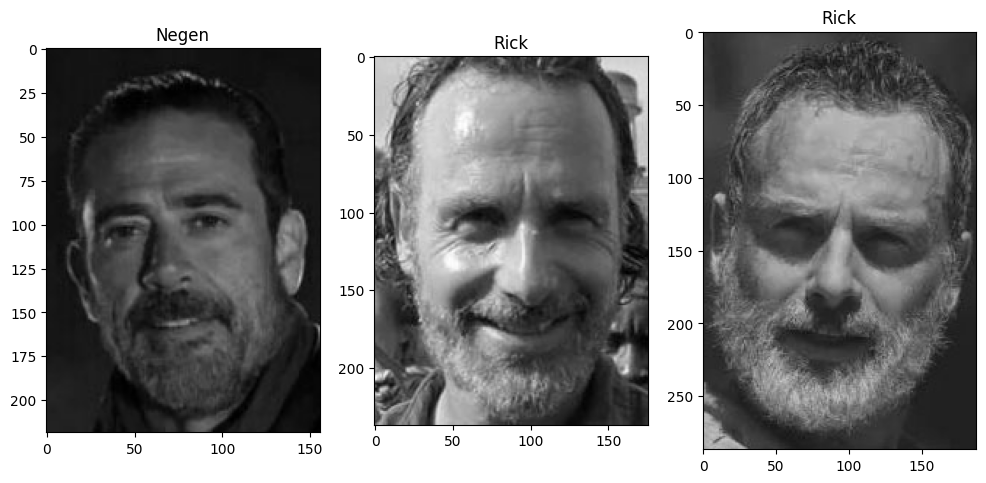

In [54]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

images = []
img0 = cv2.imread('./image/LBPH11.jpg', 0)     # Negen
img1 = cv2.imread('./image/LBPH12.jpg', 0)     # Rick
predict_image=cv2.imread('./image/LBPH13.jpg', cv2.IMREAD_GRAYSCALE)  # Rick
labels = {0:'Negen', 1:'Rick'}

# img0 = cv2.imread('./image/LBPH21.jpg', 0)     # Tom Cruise
# img1 = cv2.imread('./image/LBPH22.jpg', 0)     # Tom Hanks
# predict_image=cv2.imread('./image/LBPH29_1.jpg', cv2.IMREAD_GRAYSCALE)  # Tom Hanks
# labels = {0:'Tom Cruise', 1:'Tom Hanks'}

# img0 = cv2.imread('./image/LBPH21.jpg', 0)     # Tom Cruise
# img1 = cv2.imread('./image/LBPH24.jpg', 0)     # Steven Rogers
# predict_image=cv2.imread('./image/LBPH29_1.jfif', cv2.IMREAD_GRAYSCALE)  # Steve Rogers
# labels = {0:'Tom Cruise', 1:'Steve Rogers'}

images.append(img0)
images.append(img1)

recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.train(images, np.array(list(labels.keys())))
label, distance=recognizer.predict(predict_image)

print(f'匹配的人臉為\t: {labels[label]}\ndistance\t: {distance}')

plt.figure(figsize=(12, 9))                # 使用 Matplotlib 顯示圖片
plt.subplot(131)
plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)), plt.title(labels[0])

plt.subplot(132)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)), plt.title(labels[1])

plt.subplot(133)
plt.imshow(cv2.cvtColor(predict_image, cv2.COLOR_BGR2RGB)), plt.title(labels[label])
plt.imshow

## 16-3: OpenCV 實作人臉辨識

> Cascade classifier for Haar features 有很多種類; 人臉, 眼睛, 耳朵, 嘴... 甚至可以自己訓練一套專屬用途的.

> haar cascades 資源

> * haarcascade_frontalface_default.xml → 人臉
> * haarcascade_eye_tree_eyeglasses.xml → 眼睛
> * haarcascade_frontalface_alt_tree.xml
> * haarcascade_frontalface_alt.xml
> * haarcascade_frontalface_alt2.xml

#### face_cascade.detectMultiScale()
> * detectMultiScale 為偵測特徵的功能
> * gray 是灰階圖片
> * scaleFactor 圖像縮放比例，類似相機X倍鏡頭
> * minNeighbors 針對特徵點附近進行檢測
> * minSize 特徵檢測點的最小尺寸

In [55]:
import cv2
# haarcascade_frontalface_default.xml  人臉正面與側面
# face_cascade = cv2.CascadeClassifier(r'./model/haarcascade_frontalface_default.xml')

# haarcascade_frontalface_alt2.xml     人臉正面效果較好
face_cascade = cv2.CascadeClassifier(r'./model/haarcascade_frontalface_alt2.xml')

# haarcascade_profileface.xml         人臉側面效果較好
# face_cascade = cv2.CascadeClassifier(r'./model/haarcascade_profileface.xml')

# haarcascade_eye.xml                 眼睛偵測
# face_cascade = cv2.CascadeClassifier(r'./model/haarcascade_eye.xml')

image = cv2.imread('./image/faces.jpg')
# image = cv2.imread('./image/faces.png')
# image = cv2.imread('./image/faces01.jpg')
# image = cv2.imread('./image/faces02.png')
image=cv2.resize(image, (900, 600))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.2, 6, minSize=(5, 5), maxSize=(300, 300))   # image, scaleFactor=1.1, minNeighbor=6
# faces = face_cascade.detectMultiScale(gray, 1.05, 4)   # 參數調整
print(faces)
print(f'find {len(faces)} faces in image ')
for (x, y, w, h) in faces:
    image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)

# cv2.namedWindow('video', cv2.WINDOW_NORMAL)
cv2.imshow('result', image)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

[[682 131 200 200]
 [348 115 209 209]
 [159 112 230 230]]
find 3 faces in image 


-1

### Full body

In [56]:
# ch27_7.py
import cv2

pictPath = r'./model/haarcascade_fullbody.xml'
body_cascade = cv2.CascadeClassifier(pictPath)      # 建立辨識物件
# img = cv2.imread("./image/people1.jpg")                     # 讀取影像
img = cv2.imread("./image/fullbody.jpg")                     # 讀取影像
bodies = body_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors = 2, minSize=(20,20))
# 標註身體
for (x,y,w,h) in bodies:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)  # 藍色框住身體
cv2.imshow("Body", img)                             # 顯示影像

cv2.waitKey(0)
cv2.destroyAllWindows()

### upper lower body

In [57]:
# ch27_9.py
import cv2

# pictPath = r'./model/haarcascade_upperbody.xml'
pictPath = r'./model/haarcascade_lowerbody.xml'

body_cascade = cv2.CascadeClassifier(pictPath)      # 建立辨識物件
img = cv2.imread("./image/fullbody.jpg")                     # 讀取影像
bodies = body_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors = 3, minSize=(20,20))
# 標註身體
for (x,y,w,h) in bodies:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)  # 藍色框住身體
cv2.imshow("Body", img)                             # 顯示影像

cv2.waitKey(0)
cv2.destroyAllWindows()

### Car Plate

In [58]:
# ch27_18.py
import cv2

pictPath = r'./model/haarcascade_russian_plate_number.xml'
car_cascade = cv2.CascadeClassifier(pictPath)       # 建立辨識物件
img = cv2.imread("./image/CarPlate1.jpg")
# img = cv2.imread("./image/car1.jpg")
# img = cv2.imread("./image/car2.jpg")                        # 讀取影像
# 讀取影像
plates = car_cascade.detectMultiScale(img, scaleFactor=1.025, minNeighbors = 2, minSize=(20,20))
# 將車牌框起來, 由於有可能找到好幾個臉所以用迴圈繪出來
for (x,y,w,h) in plates:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)  # 藍色框住車牌
cv2.imshow("Car Plate", img)                        # 顯示影像

cv2.waitKey(0)
cv2.destroyAllWindows()

### capture images from video

In [59]:
import cv2, time
import winsound
import os

n = 1       # 存檔檔名用
index = 0   # 人臉取樣總數
total = 50
if not os.path.exists("./image/h0"):                  # 如果不存在資料夾
    os.mkdir("./image/h0") 
    
def saveImage(face_image, index):
    filename = f'./image/h0/{index:02d}.jpg'
    cv2.imwrite(filename, face_image)
    print(filename)

face_cascade = cv2.CascadeClassifier(r'./model/haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)
# cv2.namedWindow('video', cv2.WINDOW_NORMAL)
time.sleep(3)

while n > 0:
    ret, frame = cap.read()
    if not ret or cv2.waitKey(1) == 27 : break
    
#     frame = cv2.resize(frame, (600, 336))
    frame = cv2.flip(frame, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    for (x, y, w, h) in faces:
        frame = cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
        if n % 3 == 0:
            face_image = cv2.resize(gray[y: y + h, x: x + w], (400, 400))
            saveImage(face_image, index)

            index += 1
            if index >= total:
                print('get training data done')
                n = -1
                winsound.PlaySound("SystemExit", winsound.SND_ALIAS)
                break
        n += 1
    cv2.imshow('video', frame)
#     cv2.waitKey(0)
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1) 

./image/h0/00.jpg
./image/h0/01.jpg
./image/h0/02.jpg
./image/h0/03.jpg
./image/h0/04.jpg
./image/h0/05.jpg
./image/h0/06.jpg
./image/h0/07.jpg
./image/h0/08.jpg
./image/h0/09.jpg
./image/h0/10.jpg
./image/h0/11.jpg
./image/h0/12.jpg
./image/h0/13.jpg
./image/h0/14.jpg
./image/h0/15.jpg
./image/h0/16.jpg
./image/h0/17.jpg
./image/h0/18.jpg
./image/h0/19.jpg
./image/h0/20.jpg
./image/h0/21.jpg
./image/h0/22.jpg
./image/h0/23.jpg
./image/h0/24.jpg
./image/h0/25.jpg
./image/h0/26.jpg
./image/h0/27.jpg
./image/h0/28.jpg
./image/h0/29.jpg
./image/h0/30.jpg
./image/h0/31.jpg
./image/h0/32.jpg
./image/h0/33.jpg


-1

### train 1 dir/ obj : LBPH
LBPH : https://kknews.cc/zh-tw/tech/2mz68e.html

In [60]:
import cv2
import numpy as np
n = 1       # 存檔檔名用
index = 0   # 人臉取樣總數
total = 50

images = []; labels = []

for index in range(total):
    filename = './image/h0/{:02d}.jpg'.format(index)
#     print('read ' + filename)
    img = cv2.imread(filename, cv2.COLOR_BGR2GRAY)
    if isinstance(img, np.ndarray):                     # if existed, append....
        print('read ' + filename+' done')
        images.append(img)
        labels.append(0)    # 第一張人臉的標籤為0
    else :
        print('read ' + filename+' not exists')

print('training...')
model = cv2.face.LBPHFaceRecognizer_create(radius=1, neighbors=8)    # LBPH
model.train(images, np.array(labels))      # train 只接受 numpy array
model.save('./model/faces.data')
print('training done')

read ./image/h0/00.jpg done
read ./image/h0/01.jpg done
read ./image/h0/02.jpg done
read ./image/h0/03.jpg done
read ./image/h0/04.jpg done
read ./image/h0/05.jpg done
read ./image/h0/06.jpg done
read ./image/h0/07.jpg done
read ./image/h0/08.jpg done
read ./image/h0/09.jpg done
read ./image/h0/10.jpg done
read ./image/h0/11.jpg done
read ./image/h0/12.jpg done
read ./image/h0/13.jpg done
read ./image/h0/14.jpg done
read ./image/h0/15.jpg done
read ./image/h0/16.jpg done
read ./image/h0/17.jpg done
read ./image/h0/18.jpg done
read ./image/h0/19.jpg done
read ./image/h0/20.jpg done
read ./image/h0/21.jpg done
read ./image/h0/22.jpg done
read ./image/h0/23.jpg done
read ./image/h0/24.jpg done
read ./image/h0/25.jpg done
read ./image/h0/26.jpg done
read ./image/h0/27.jpg done
read ./image/h0/28.jpg done
read ./image/h0/29.jpg done
read ./image/h0/30.jpg done
read ./image/h0/31.jpg done
read ./image/h0/32.jpg done
read ./image/h0/33.jpg done
read ./image/h0/34.jpg not exists
read ./image/h

### train 2 or more dir/ obj
LBPH, Eigen, Fisher

In [61]:
import os
import cv2
import numpy as np

images = []; labels = []
path='.\image'

for objname in os.listdir(path):
    fullname= os.path.join(path, objname)
#     print(fullname)
    if os.path.isdir(fullname) and objname[0] == 'h' :
        print(fullname, objname)
        for pict in os.listdir(fullname):
#             print(fullname+'\\'+pict)
            if pict[0]!='.' :
                img = cv2.imread(fullname+'\\'+pict, cv2.COLOR_BGR2GRAY)
                print('read ' + fullname+'\\'+pict+' done ,  ', 'object/ label : ', objname)
                images.append(img)
                labels.append(int(objname[-1]))                                # 第一張人臉的標籤為

print('training...')
model = cv2.face.LBPHFaceRecognizer_create()
# model = cv2.face.EigenFaceRecognizer_create()
# model = cv2.face.FisherFaceRecognizer_create()
model.train(images, np.array(labels))
model.save('./model/faces.data')
print('training done', model)

.\image\h0 h0
read .\image\h0\00.jpg done ,   object/ label :  h0
read .\image\h0\01.jpg done ,   object/ label :  h0
read .\image\h0\02.jpg done ,   object/ label :  h0
read .\image\h0\03.jpg done ,   object/ label :  h0
read .\image\h0\04.jpg done ,   object/ label :  h0
read .\image\h0\05.jpg done ,   object/ label :  h0
read .\image\h0\06.jpg done ,   object/ label :  h0
read .\image\h0\07.jpg done ,   object/ label :  h0
read .\image\h0\08.jpg done ,   object/ label :  h0
read .\image\h0\09.jpg done ,   object/ label :  h0
read .\image\h0\10.jpg done ,   object/ label :  h0
read .\image\h0\11.jpg done ,   object/ label :  h0
read .\image\h0\12.jpg done ,   object/ label :  h0
read .\image\h0\13.jpg done ,   object/ label :  h0
read .\image\h0\14.jpg done ,   object/ label :  h0
read .\image\h0\15.jpg done ,   object/ label :  h0
read .\image\h0\16.jpg done ,   object/ label :  h0
read .\image\h0\17.jpg done ,   object/ label :  h0
read .\image\h0\18.jpg done ,   object/ label :  h

### recognition : LBPH
> LBPH 愈低愈好, 低於 50 可接受

In [62]:
import cv2

model = cv2.face.LBPHFaceRecognizer_create()     # 要與 train 時的演算法一致 
# model = cv2.face.EigenFaceRecognizer_create()     # 要與 train 時的演算法一致 
# model = cv2.face.FisherFaceRecognizer_create()     # 要與 train 時的演算法一致 
model.read('./model/faces.data')
print('load training data done')

face_cascade = cv2.CascadeClassifier(r'./model/haarcascade_frontalface_default.xml')

# haarcascade_frontalface_alt2.xml     人臉正面效果較好
# face_cascade = cv2.CascadeClassifier(r'./model/haarcascade_frontalface_alt2.xml')

# face_cascade = cv2.CascadeClassifier(r'./model/haarcascade_eye.xml')
cap = cv2.VideoCapture(0)

# 可識別化名稱
names = ['Steve']
font = 2;    lt = 16

while True:
    ret, frame = cap.read()
    if not ret or cv2.waitKey(1) == 27 : break
#     frame = cv2.resize(frame, (600, 336))
    frame = cv2.resize(frame, (frame.shape[1], frame.shape[0]))
    frame = cv2.flip(frame, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.1, 3)
    for (x, y, w, h) in faces:
        frame = cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
        face_image = cv2.resize(gray[y: y + h, x: x + w], (400, 400))
        try:
            val = model.predict(face_image)                          # predict 傳回標籤編號和信心值
            if val[1] < 50:
                cv2.putText( frame, names[val[0]]+' : '+str(val[1])[:5], 
                    (x, y-10), font, 1, (255,255,0), 3, lt)
        except:
            continue

    cv2.imshow('video', frame)
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1) 

load training data done


-1

---

<center><h1>--- the end ---</h1></center>